<a href="https://colab.research.google.com/github/m-zaniolo/CEE690-ESAA/blob/main/L02_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 - indicators

Load data and packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 600


inflow = np.loadtxt('data/inflow.txt', delimiter='\t') #m3/s

Pandas offers convenient functionalities to handle dates.

In [ ]:
# generate date array
# Generate the full date range from January 1, 2001, to December 31, 2015
date_range = pd.date_range(start='2001-01-01', end='2015-12-31', freq='D')

# Filter out all February 29 instances
date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]


some useful functions:
 `convolve`, `reshape`, `concatenate`


In [ ]:
# Define the window size for convolution
window_size = 7

# Calculate the rolling window average
rolling_avg = np.convolve(inflow, np.ones(window_size)/window_size, mode='valid')

#note: the convolution creates a shorter rolling average array. Namely, len(rolling_avg) = len(inflow) - (window_size - 1)
print( 'inflow timeseries length: ' + str( len(inflow) )  )
print( 'inflow rolling average length: ' + str( len(rolling_avg) )  )

inflow timeseries length: 5475
inflow rolling average length: 5469


In [ ]:
# for odd window sizes, assign values to the center of the rolling window by concatenating NaNs
semi_window = int( (window_size - 1)/2 )
concatenate_values = np.full(( semi_window,), np.nan)
rolling_avg_c = np.concatenate( [concatenate_values, rolling_avg, concatenate_values] )

# reshape to annual values
Ny = int( len(inflow) / 365 )
rolling_annual = np.reshape(rolling_avg_c, (Ny, 365))

print(rolling_annual) # matrix of dimension Nyears x 365 days where each value is the rolling weekly average.

ValueError: cannot reshape array of size 5471 into shape (15,365)

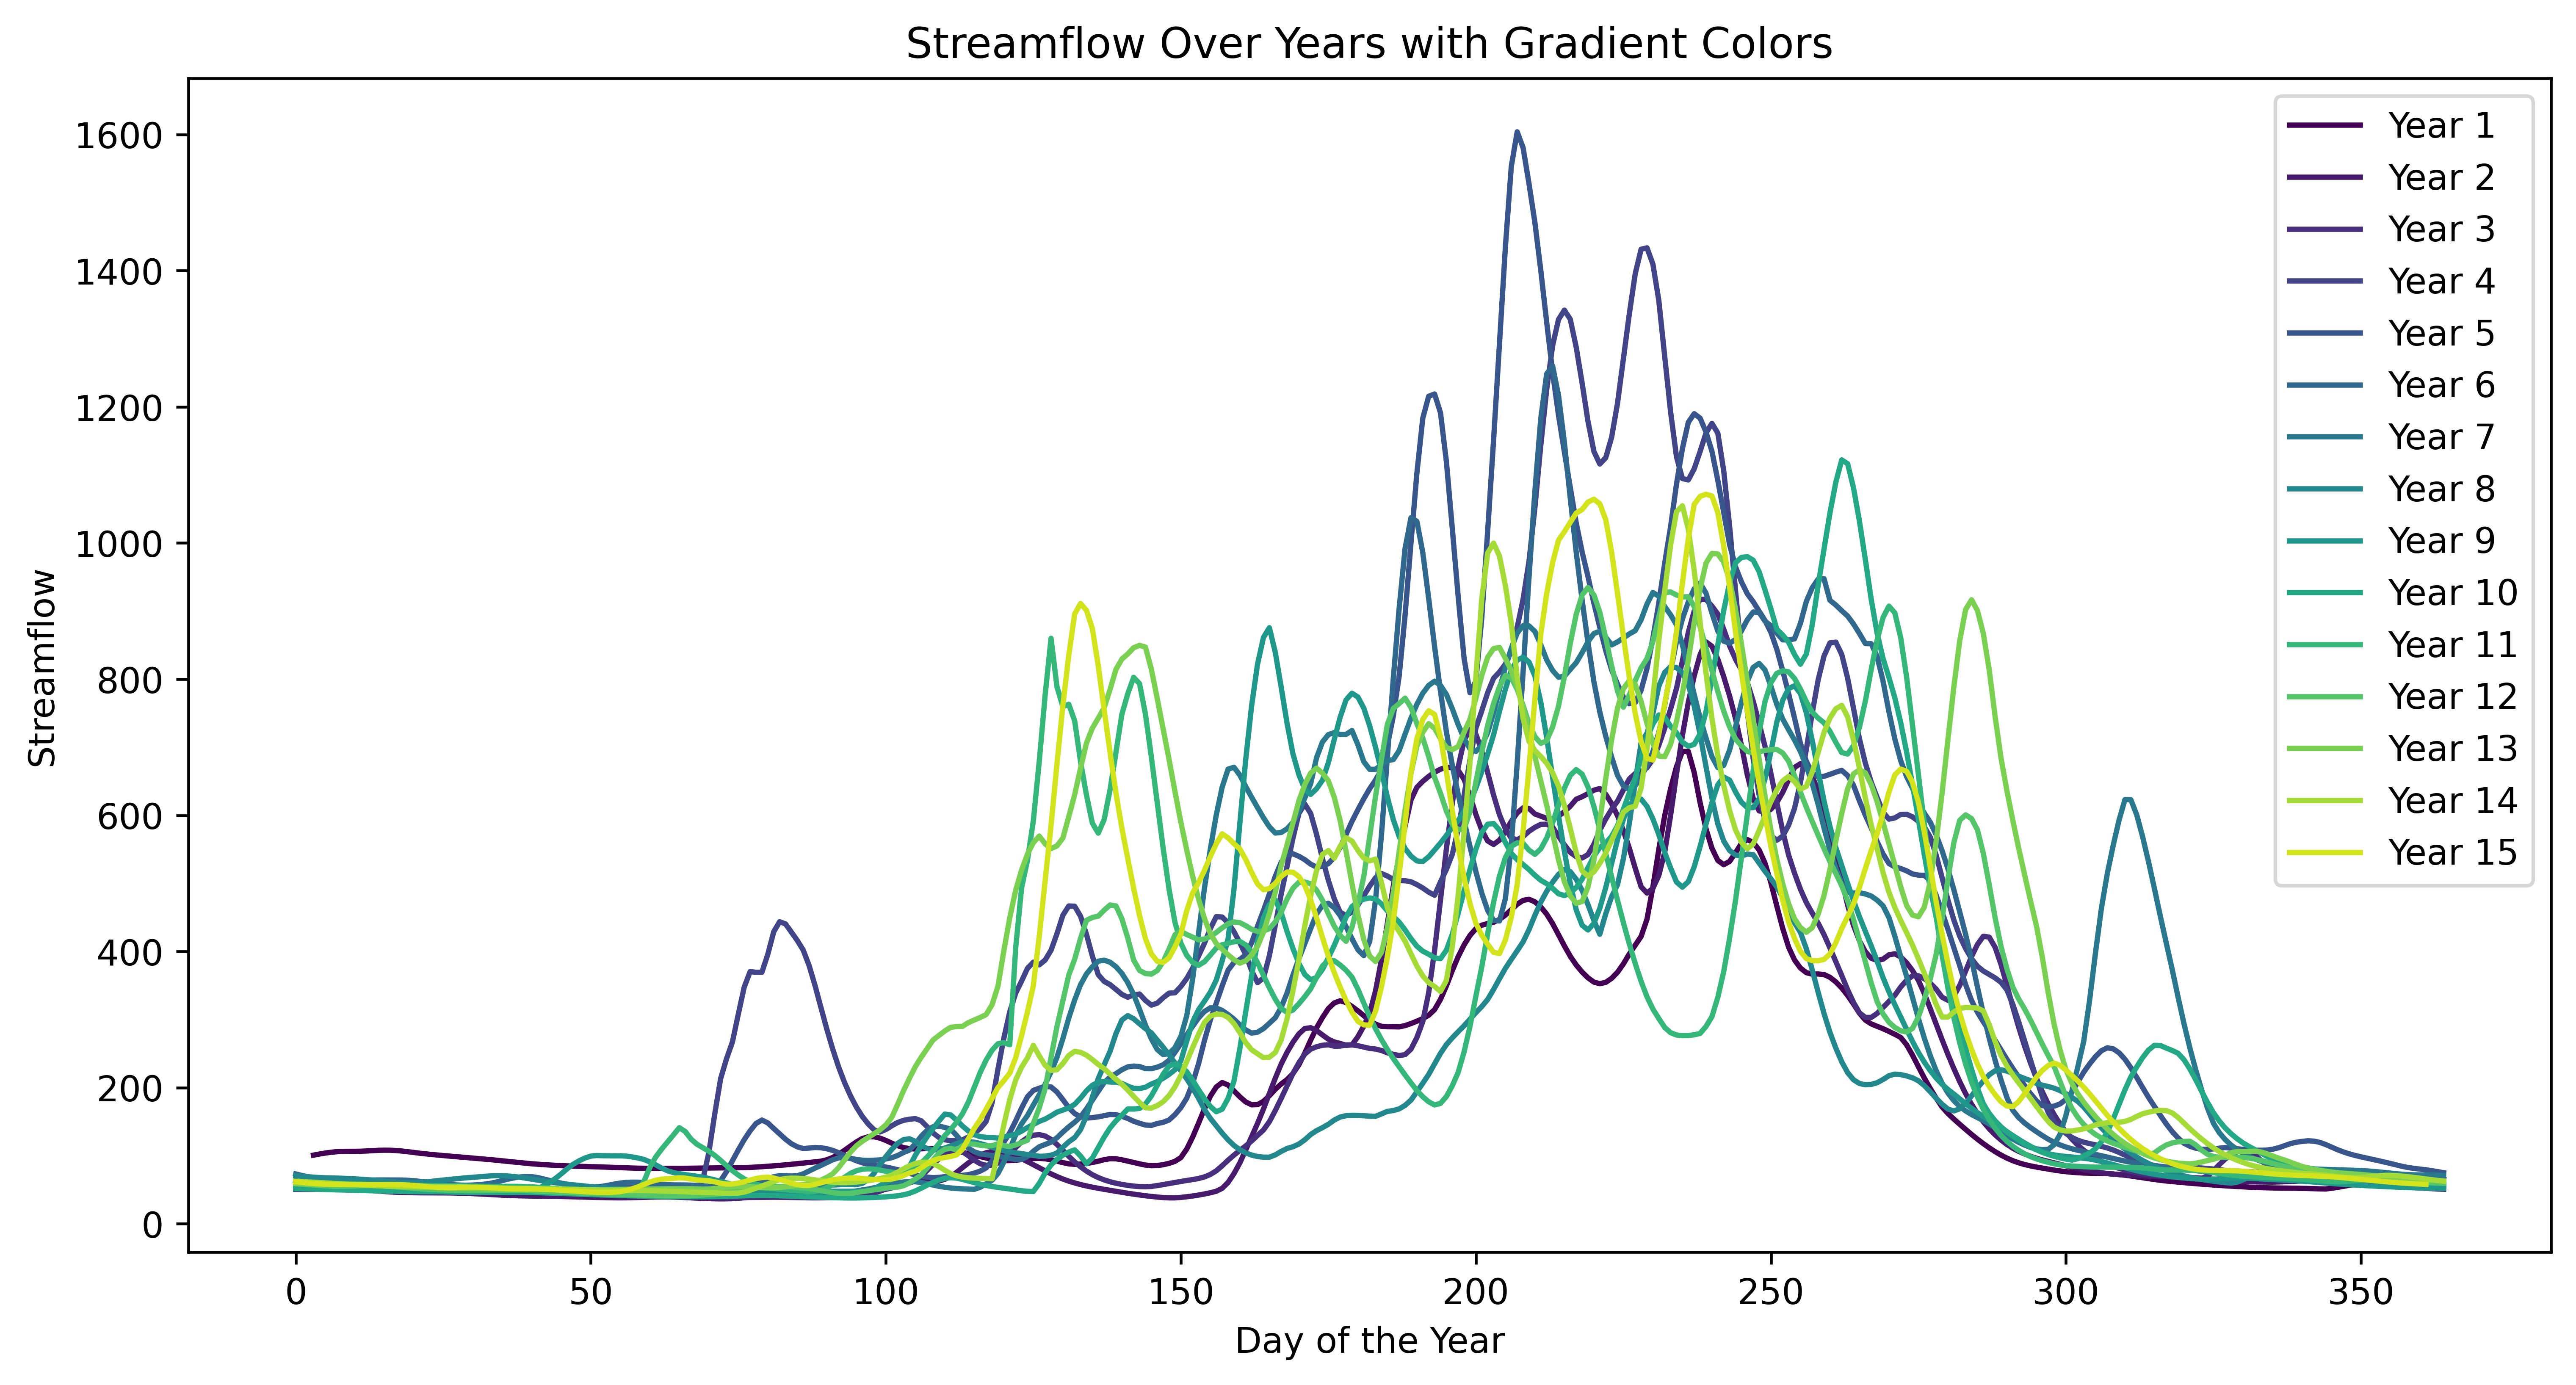

In [ ]:
# We can plot this matrix:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create a colormap
cmap = plt.get_cmap('viridis')

# Plot each year with a different color from the colormap
for i in range(Ny):
    color = cmap(i / Ny)
    ax.plot(rolling_annual[i], color=color, label=f'Year {i+1}')

# Add labels and title
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Inflow [m3/s]')
ax.set_title('Inflow Over Years with Gradient Colors')

# Show the legend
ax.legend(loc='upper right')

# Display the plot
plt.show()

##_Environment: indicators of hydrological alteration_

We consider the inflow as the unaltered flow in the location, and calculate how different reservoir operation strategies impact a representative IHA.


How much does the considered release strategies alter the annual 3-day peak flow?



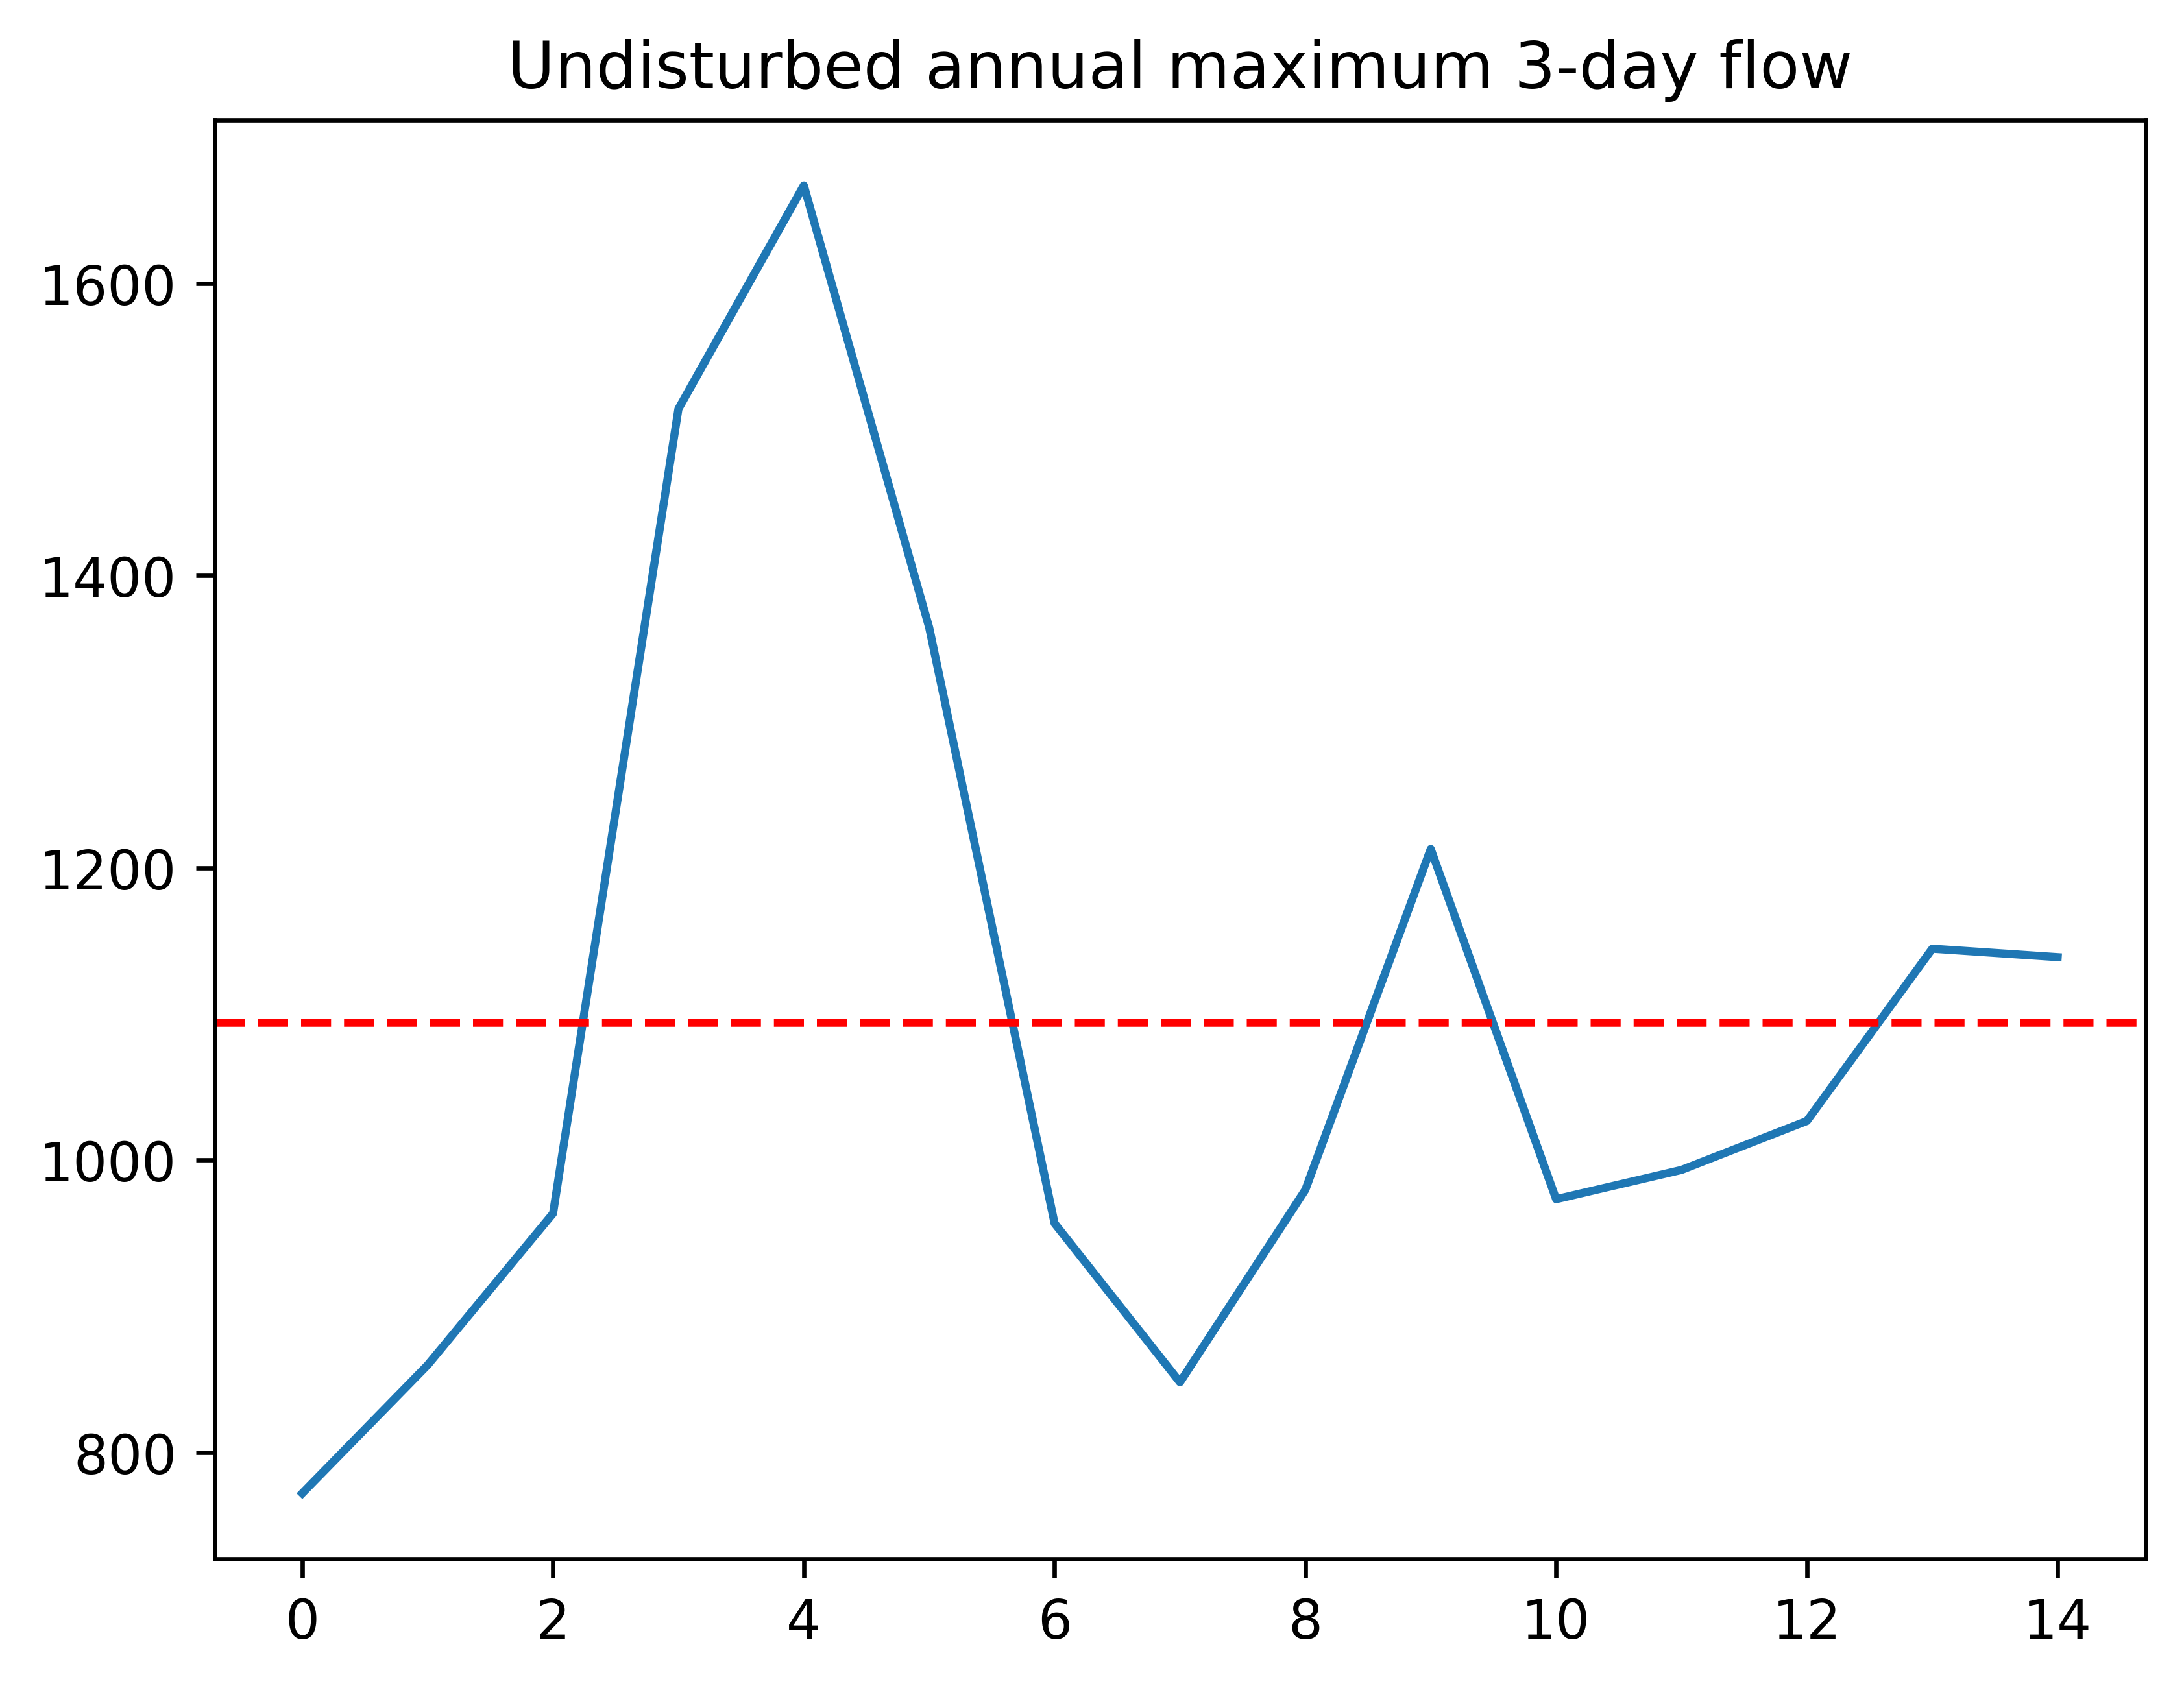

In [ ]:
window_size = 3
rolling = np.convolve(inflow, np.ones(window_size)/window_size, mode='valid')
concatenate_values = np.full(( int( (window_size - 1)/2 ),), np.nan)
rolling_avg_c = np.concatenate( [concatenate_values, rolling, concatenate_values] )
rolling_annual = np.reshape(rolling_avg_c, (Ny, 365))  #shape is in (nrows, ncolumns). Elements are arranged in rows

max3day = np.nanmax(rolling_annual, axis=1) # using the function np.max would return NaNs for the first and last year
ref_max3days = np.mean(max3day) #average 3-day peak

plt.plot(max3day)
# Plot the average maximum value as a dashed horizontal line
plt.axhline(y=ref_max3days, color='r', linestyle='--')


plt.title('Undisturbed annual maximum 3-day flow')
plt.show()

Now let's see how different release alternatives modify this IHA

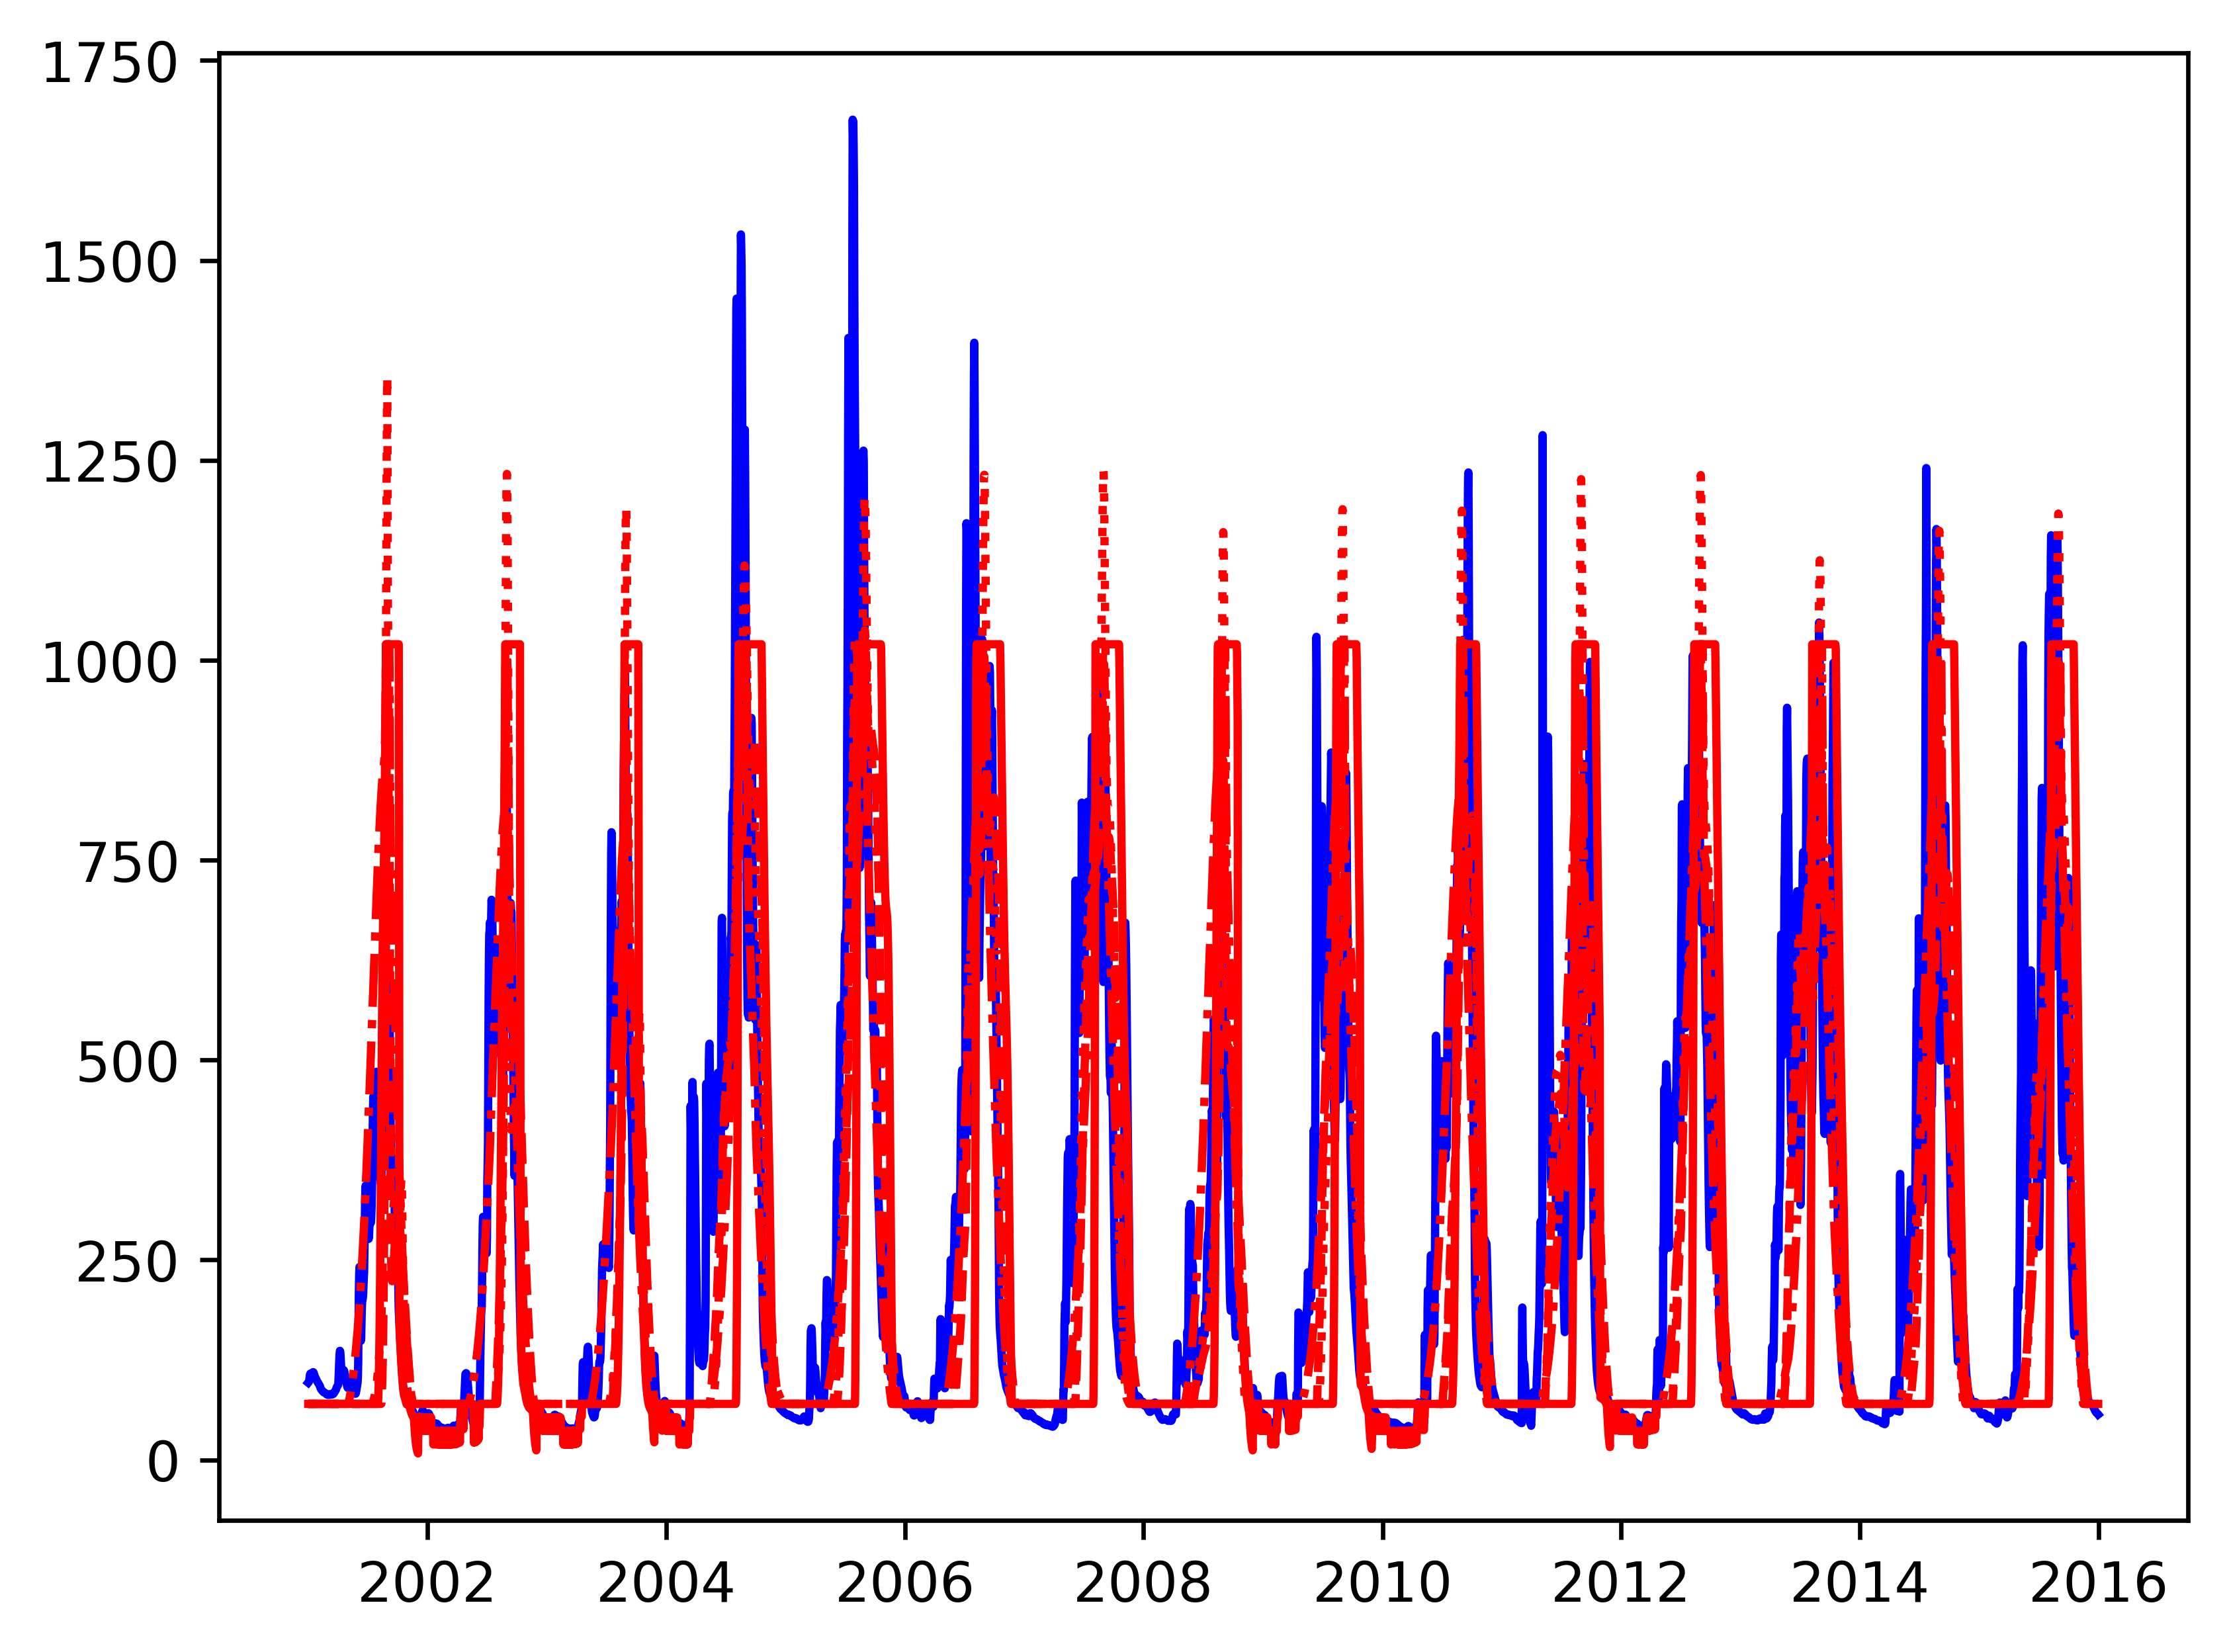

In [ ]:
# Load release alternatives and set dates
r1 = np.loadtxt('data/release1.txt', delimiter='\t') #m3/s
r2 = np.loadtxt('data/release2.txt', delimiter='\t') #m3/s
r3 = np.loadtxt('data/release3.txt', delimiter='\t') #m3/s
r4 = np.loadtxt('data/release4.txt', delimiter='\t') #m3/s

# let's have a look at these
plt.plot(date_range, inflow, color = 'b', linestyle='-')
plt.plot(date_range, r1, color = 'r', linestyle='--')
plt.plot(date_range, r2, color = 'r', linestyle='-.')
plt.plot(date_range, r3, color = 'r', linestyle=':')
plt.plot(date_range, r4, color = 'r', linestyle='-')
plt.ylabel('Flow [m3/s]')


Text(0.5, 1.0, 'Maximum 3-day flow')

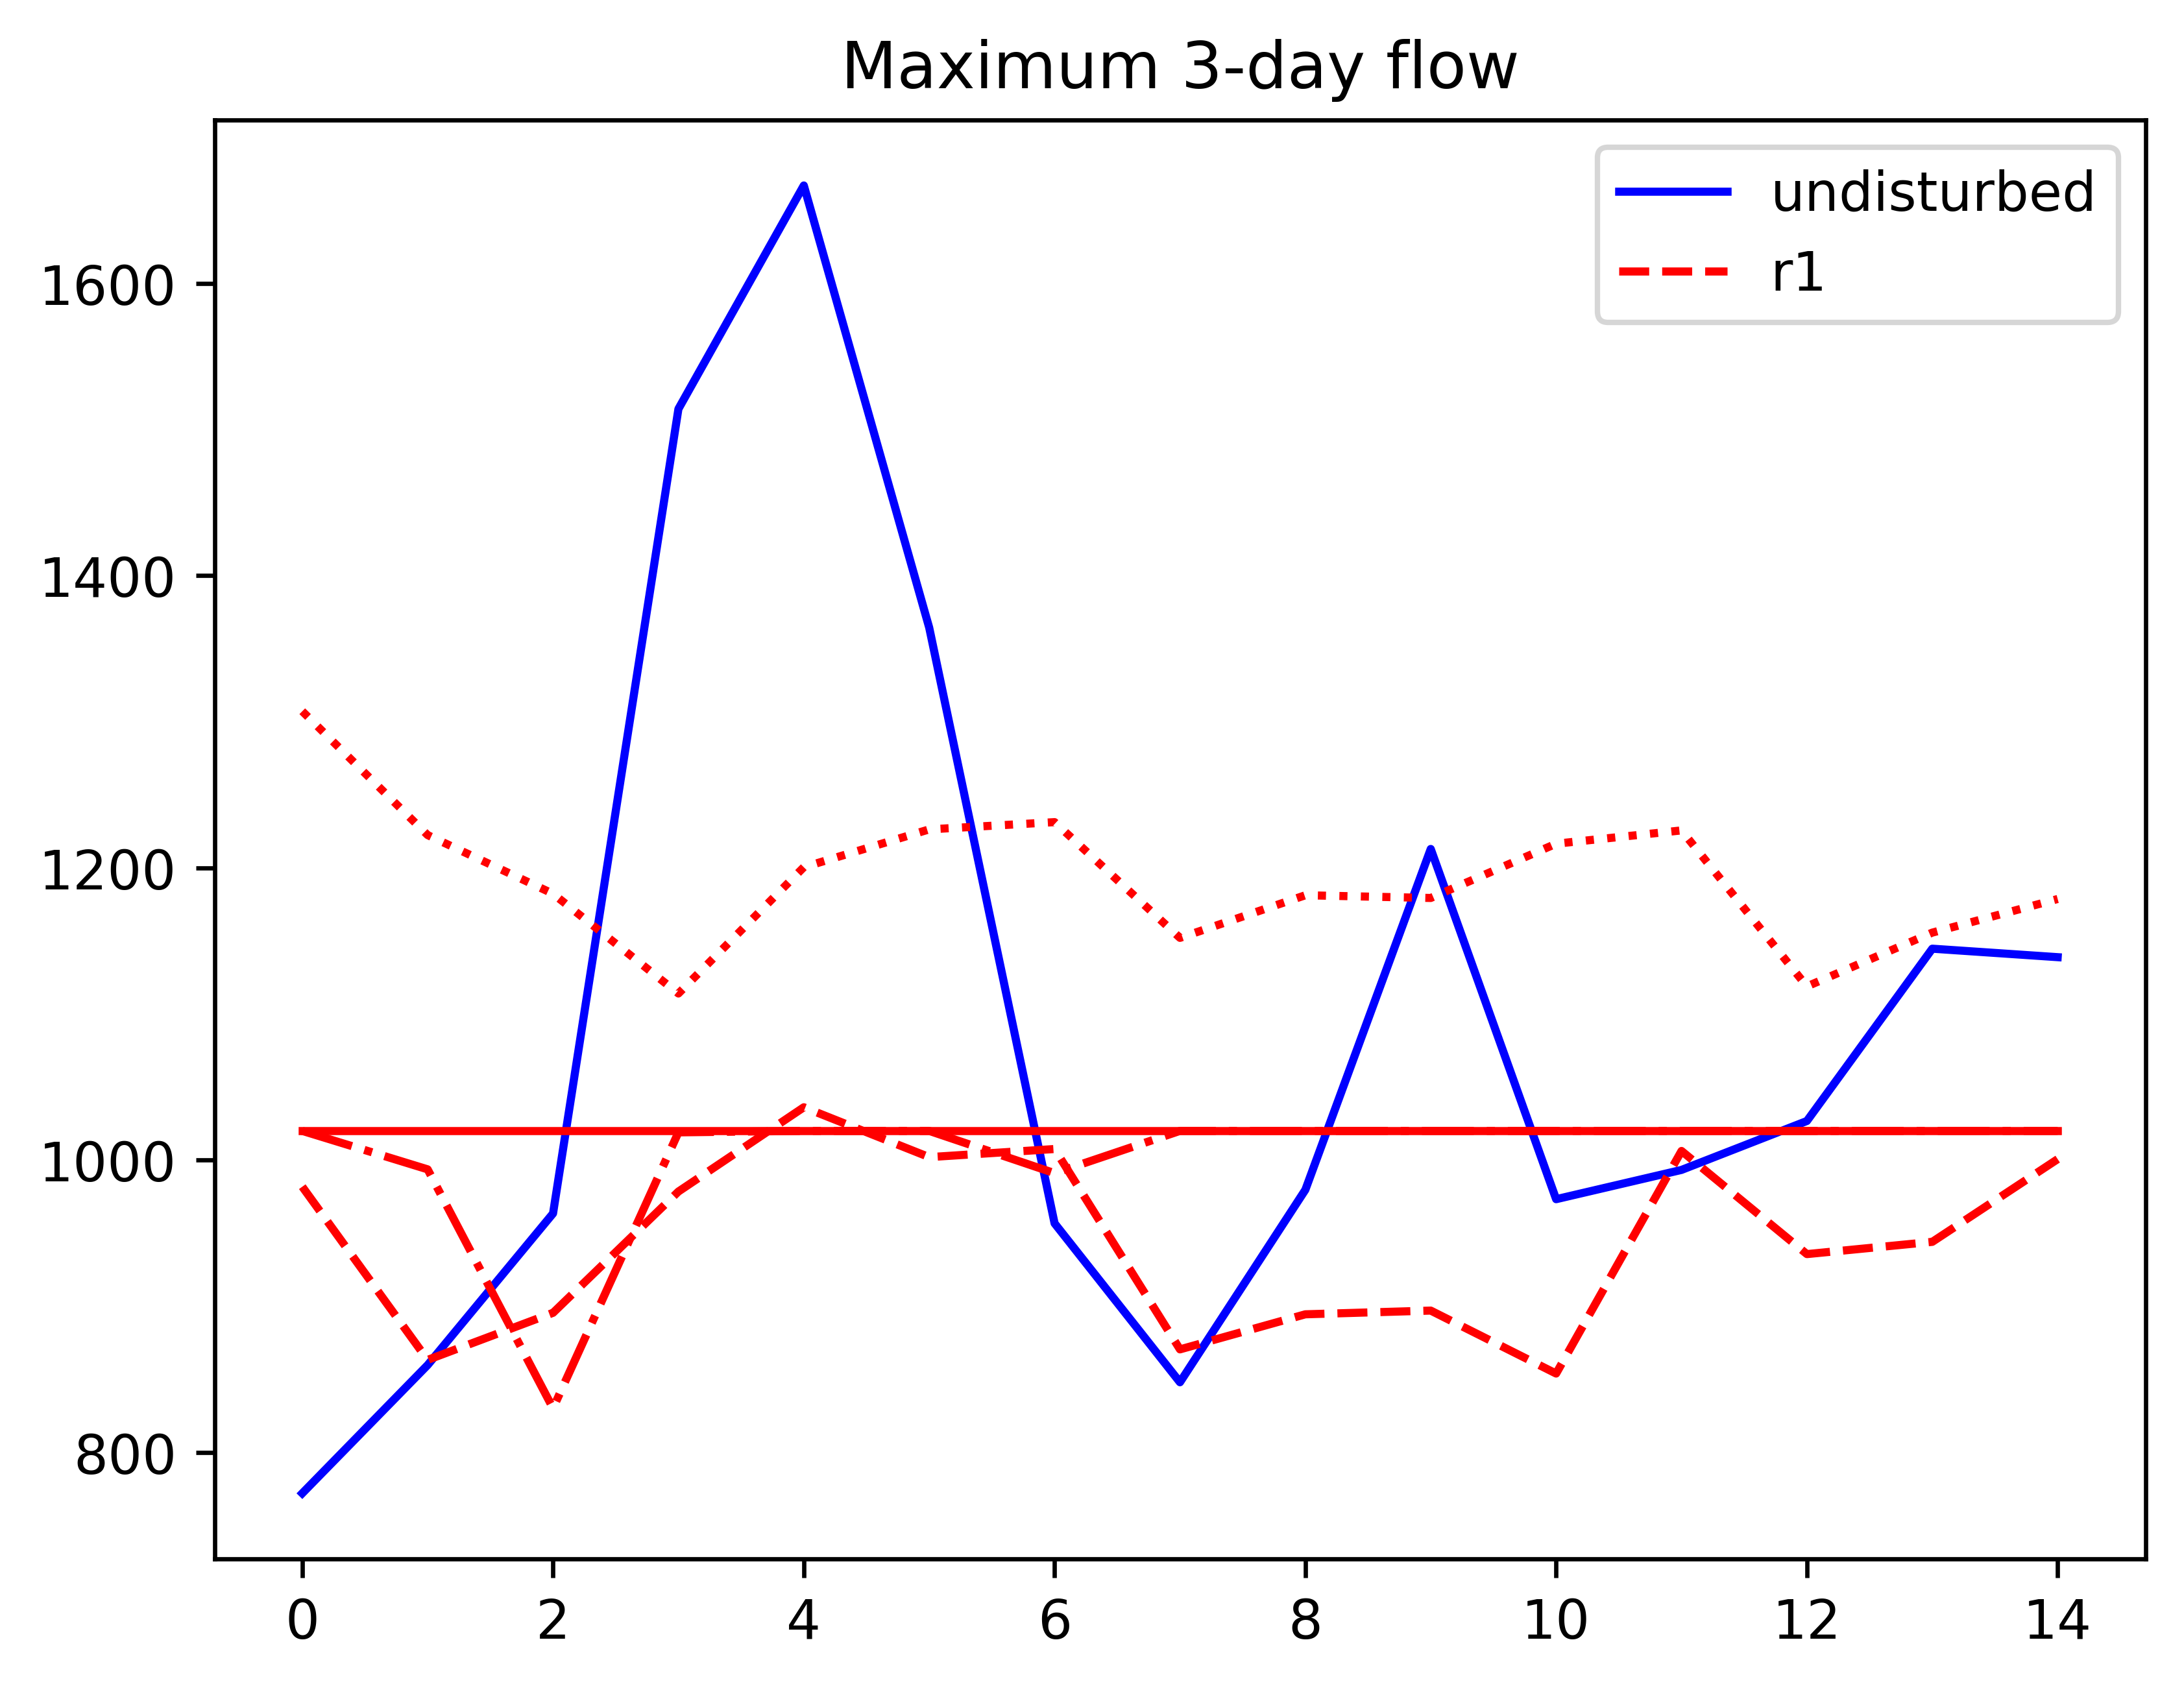

In [ ]:
# Calculate IHA for different release strategies
# Since it requires a few lines of code, we can create a function

def peakAnnualFlow(flow, window_size):

  rolling = np.convolve(flow, np.ones(window_size)/window_size, mode='valid')
  concatenate_values = np.full(( int( (window_size - 1)/2 ),), np.nan)
  rolling_avg_c = np.concatenate( [concatenate_values, rolling, concatenate_values] )
  rolling_annual = np.reshape(rolling_avg_c, (Ny, 365))

  return np.nanmax(rolling_annual, axis=1)


max3day_r1 = peakAnnualFlow(r1, window_size)
max3day_r2 = peakAnnualFlow(r2, window_size)
max3day_r3 = peakAnnualFlow(r3, window_size)
max3day_r4 = peakAnnualFlow(r4, window_size)

# Let's visualize how these release strategies alter the natural 3-day peak flow

plt.plot( max3day, color = 'b', linestyle='-', label = 'undisturbed')
plt.plot( max3day_r1, color = 'r', linestyle='--', label = 'r1')
plt.plot( max3day_r2, color = 'r', linestyle='-.', label = 'r2')
plt.plot( max3day_r3, color = 'r', linestyle=':', label = 'r3')
plt.plot( max3day_r4, color = 'r', linestyle='-', label = 'r4')
plt.legend()
plt.ylabel('Flow [m3/s]')

plt.title('Annual Maximum 3-day flow')

All strategies significantly alter the undisturbed indicator. In order to rank policies from worst to best we need to aggregate these time series.

How? For instance, we can use the absolute deviation wrt to the mean.



the release strategy that minimize the deviation wrt to the considered IHA is: 
r4


Text(0.5, 1.0, 'Average annual deviation from average annual 3-day peak flow')

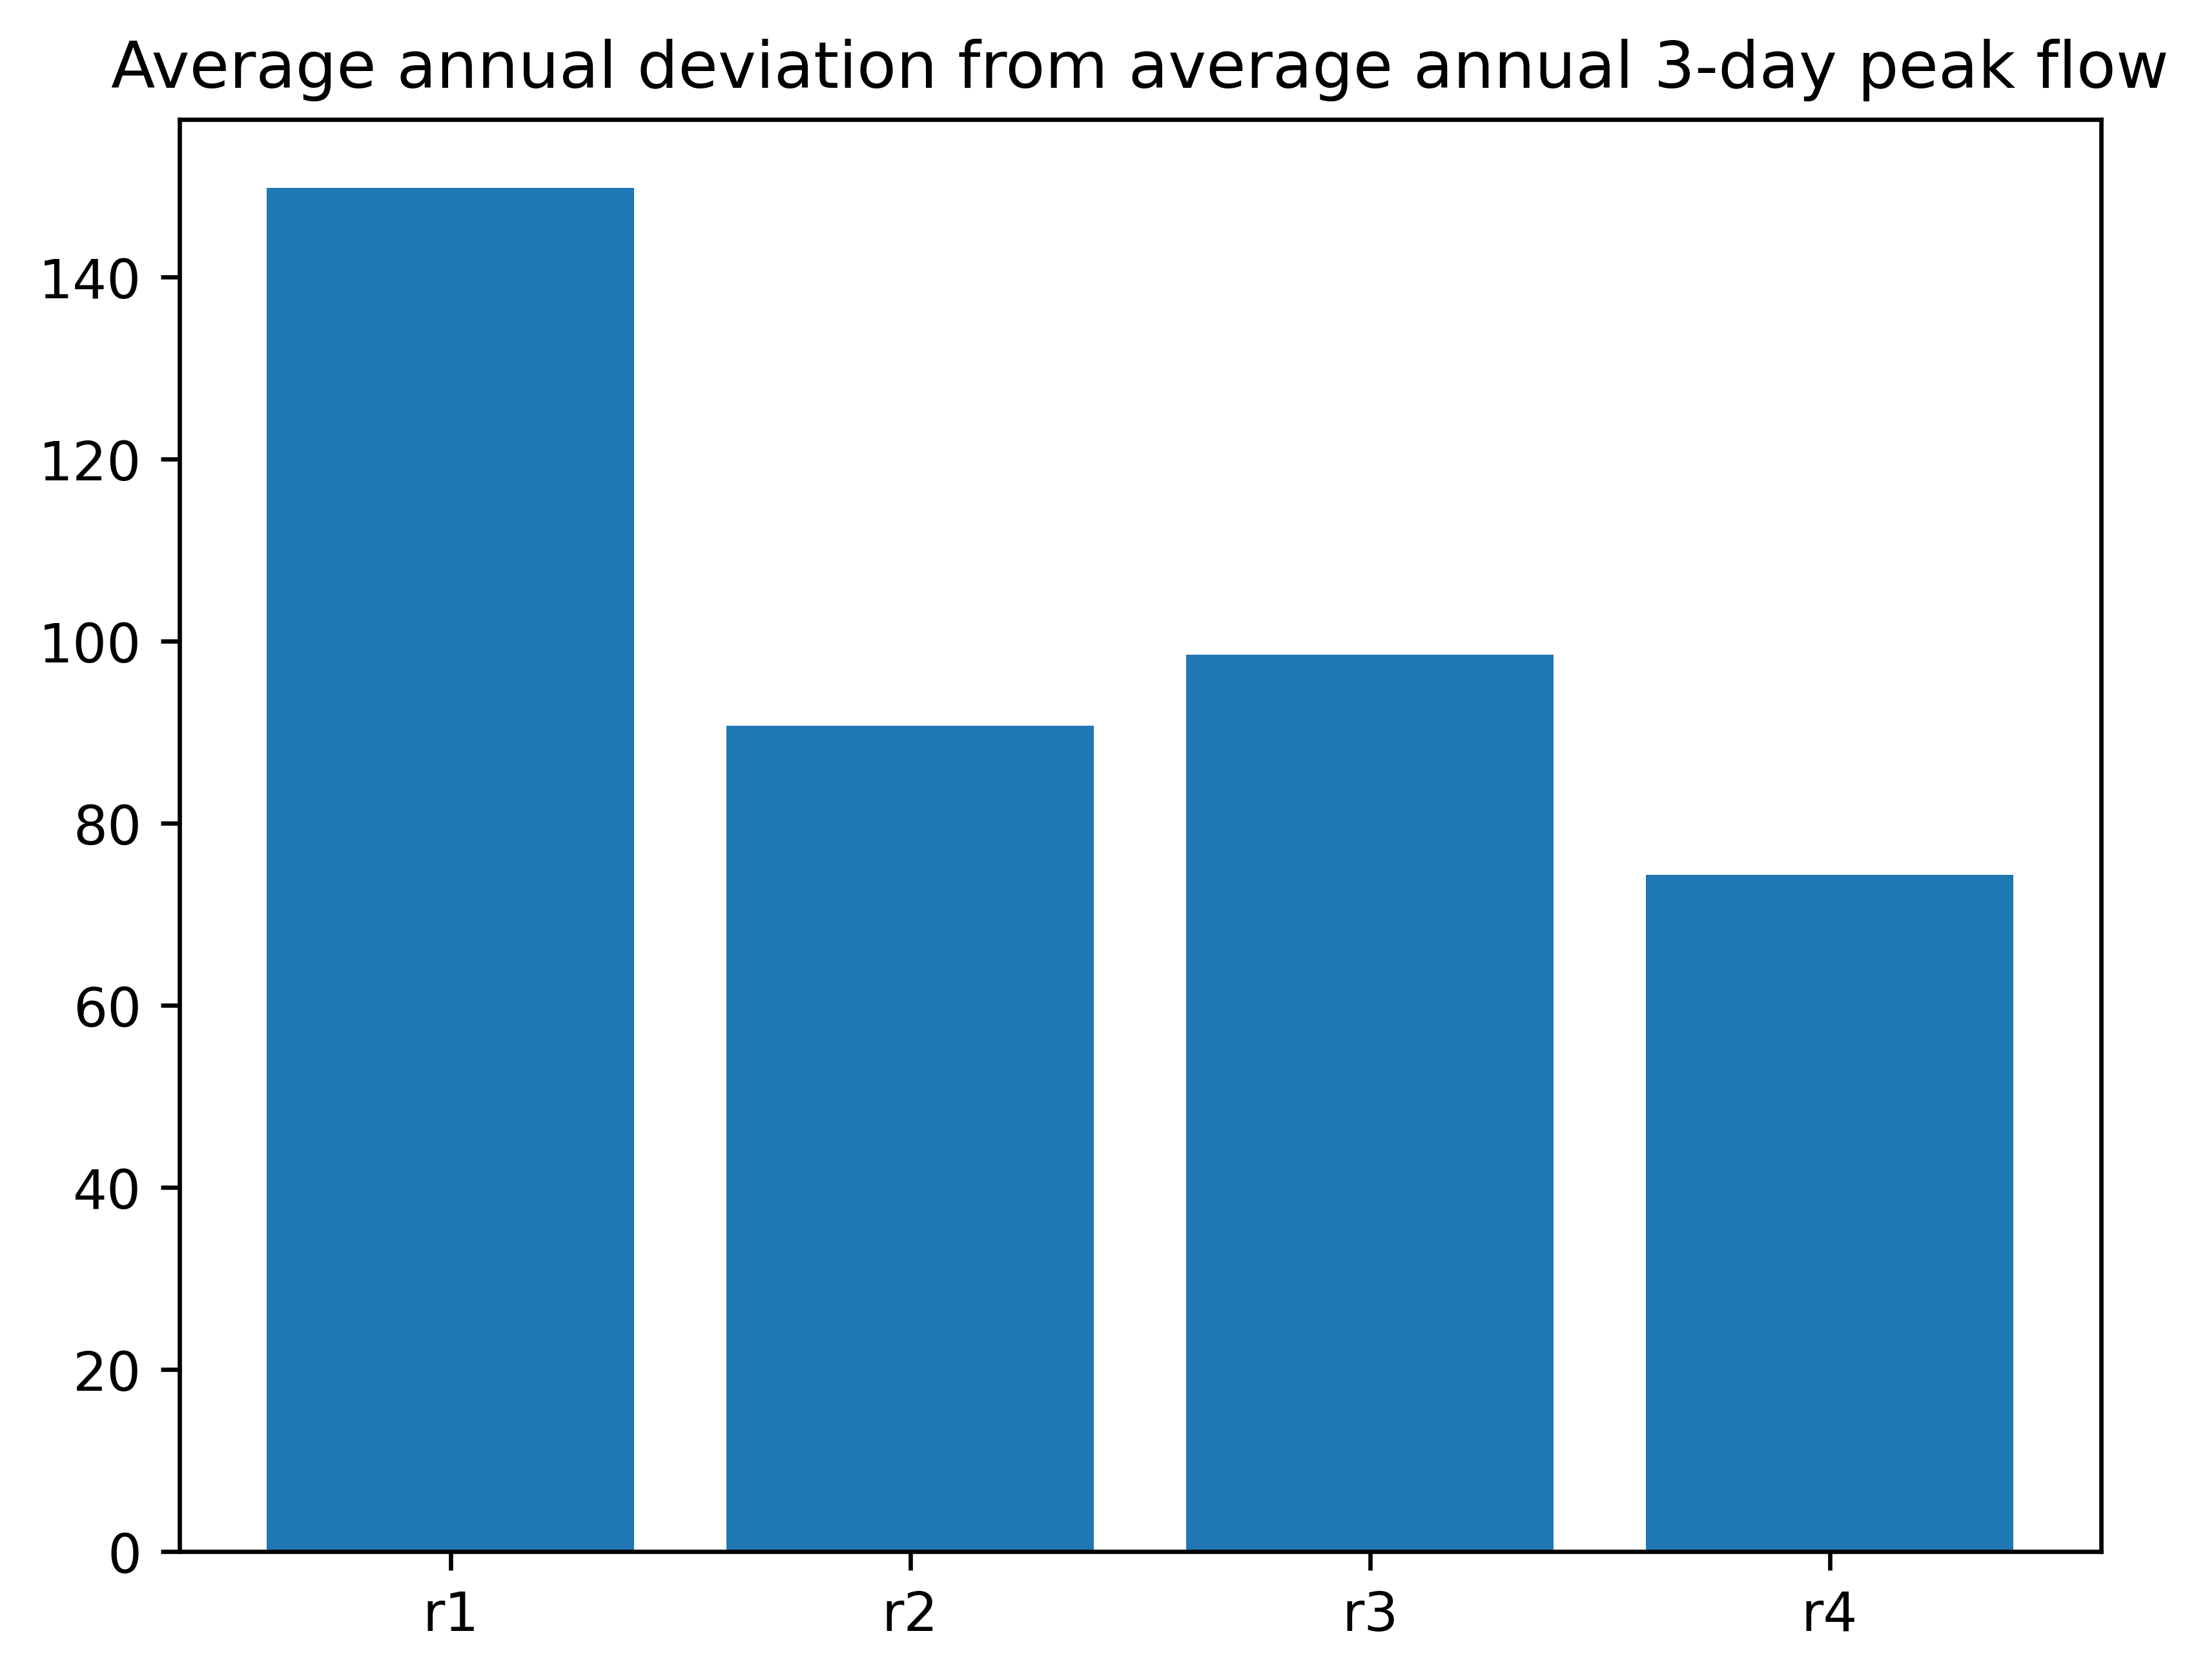

In [ ]:
#mean of the IHA for the time period
undisturbed_m3d_avg = np.mean(max3day)
r1_m3d_avg = np.mean(max3day_r1)
r2_m3d_avg = np.mean(max3day_r2)
r3_m3d_avg = np.mean(max3day_r3)
r4_m3d_avg = np.mean(max3day_r4)

Jenvironment1 = [np.abs(undisturbed_m3d_avg - r1_m3d_avg),
                       np.abs(undisturbed_m3d_avg - r2_m3d_avg),
                       np.abs(undisturbed_m3d_avg - r3_m3d_avg),
                       np.abs(undisturbed_m3d_avg - r4_m3d_avg)]

labels = ['r1', 'r2', 'r3', 'r4']
id = np.argmin(Jenvironment1)

print('the release strategy that minimize the deviation wrt to the considered IHA is: ')
print(labels[id])

# Creating the bar plot
plt.bar(labels, Jenvironment1)
plt.title('Average annual deviation from average annual 3-day peak flow')



Another relevant indicator may be the average flow in August, when recession agriculture is performed.

In [ ]:
august_start_day = 213
august_end_day = 243

#reshape to annual matrix
annual = np.reshape(inflow, (Ny , 365))
august = annual[:, august_start_day:august_end_day+1]

target_August_flow = np.mean(august)
print('Target average annual August flow: ' + str(target_August_flow) + 'm3/s')

aug_r1 = np.reshape(r1, (Ny, 365))[:, august_start_day:august_end_day+1]
aug_r2 = np.reshape(r2, (Ny, 365))[:, august_start_day:august_end_day+1]
aug_r3 = np.reshape(r3, (Ny, 365))[:, august_start_day:august_end_day+1]
aug_r4 = np.reshape(r4, (Ny, 365))[:, august_start_day:august_end_day+1]

Jenvironment2 = [ np.abs(np.mean( aug_r1 ) - target_August_flow) ,
                  np.abs(np.mean( aug_r2 ) - target_August_flow) ,
                  np.abs(np.mean( aug_r3 ) - target_August_flow) ,
                  np.abs(np.mean( aug_r4 ) - target_August_flow) ]


Target average annual August flow: 747.054688172043m3/s




---



##_Energy: hydropower production_


hydropower production can be calculated as:


hp = level * release * effic * ρ * g (W)

where ρ = 1000 kg/m3
g = 9.81 m/s2  acceleration of gravity.

To convert values to [MW] we divide by 10e6

Let's load the level timeseries we calculated last time

In [ ]:
l1 = np.loadtxt('data/level1.txt', delimiter='\t')[1:] #### fix this
l2 = np.loadtxt('data/level2.txt', delimiter='\t')[1:] #### fix this
l3 = np.loadtxt('data/level3.txt', delimiter='\t')[1:] #### fix this
l4 = np.loadtxt('data/level4.txt', delimiter='\t')[1:] #### fix this

timseries of hydropower production:

In [ ]:
efficiency = 0.9 # in realty, turbine efficiency is more complicated than a simple constant
g = 9.81
d = 1000

hp1 = l1*r1*efficiency*g*d/10e6
hp2 = l2*r2*efficiency*g*d/10e6
hp3 = l3*r3*efficiency*g*d/10e6
hp4 = l4*r4*efficiency*g*d/10e6


Aggregate hydropower production time series into a single indicator:

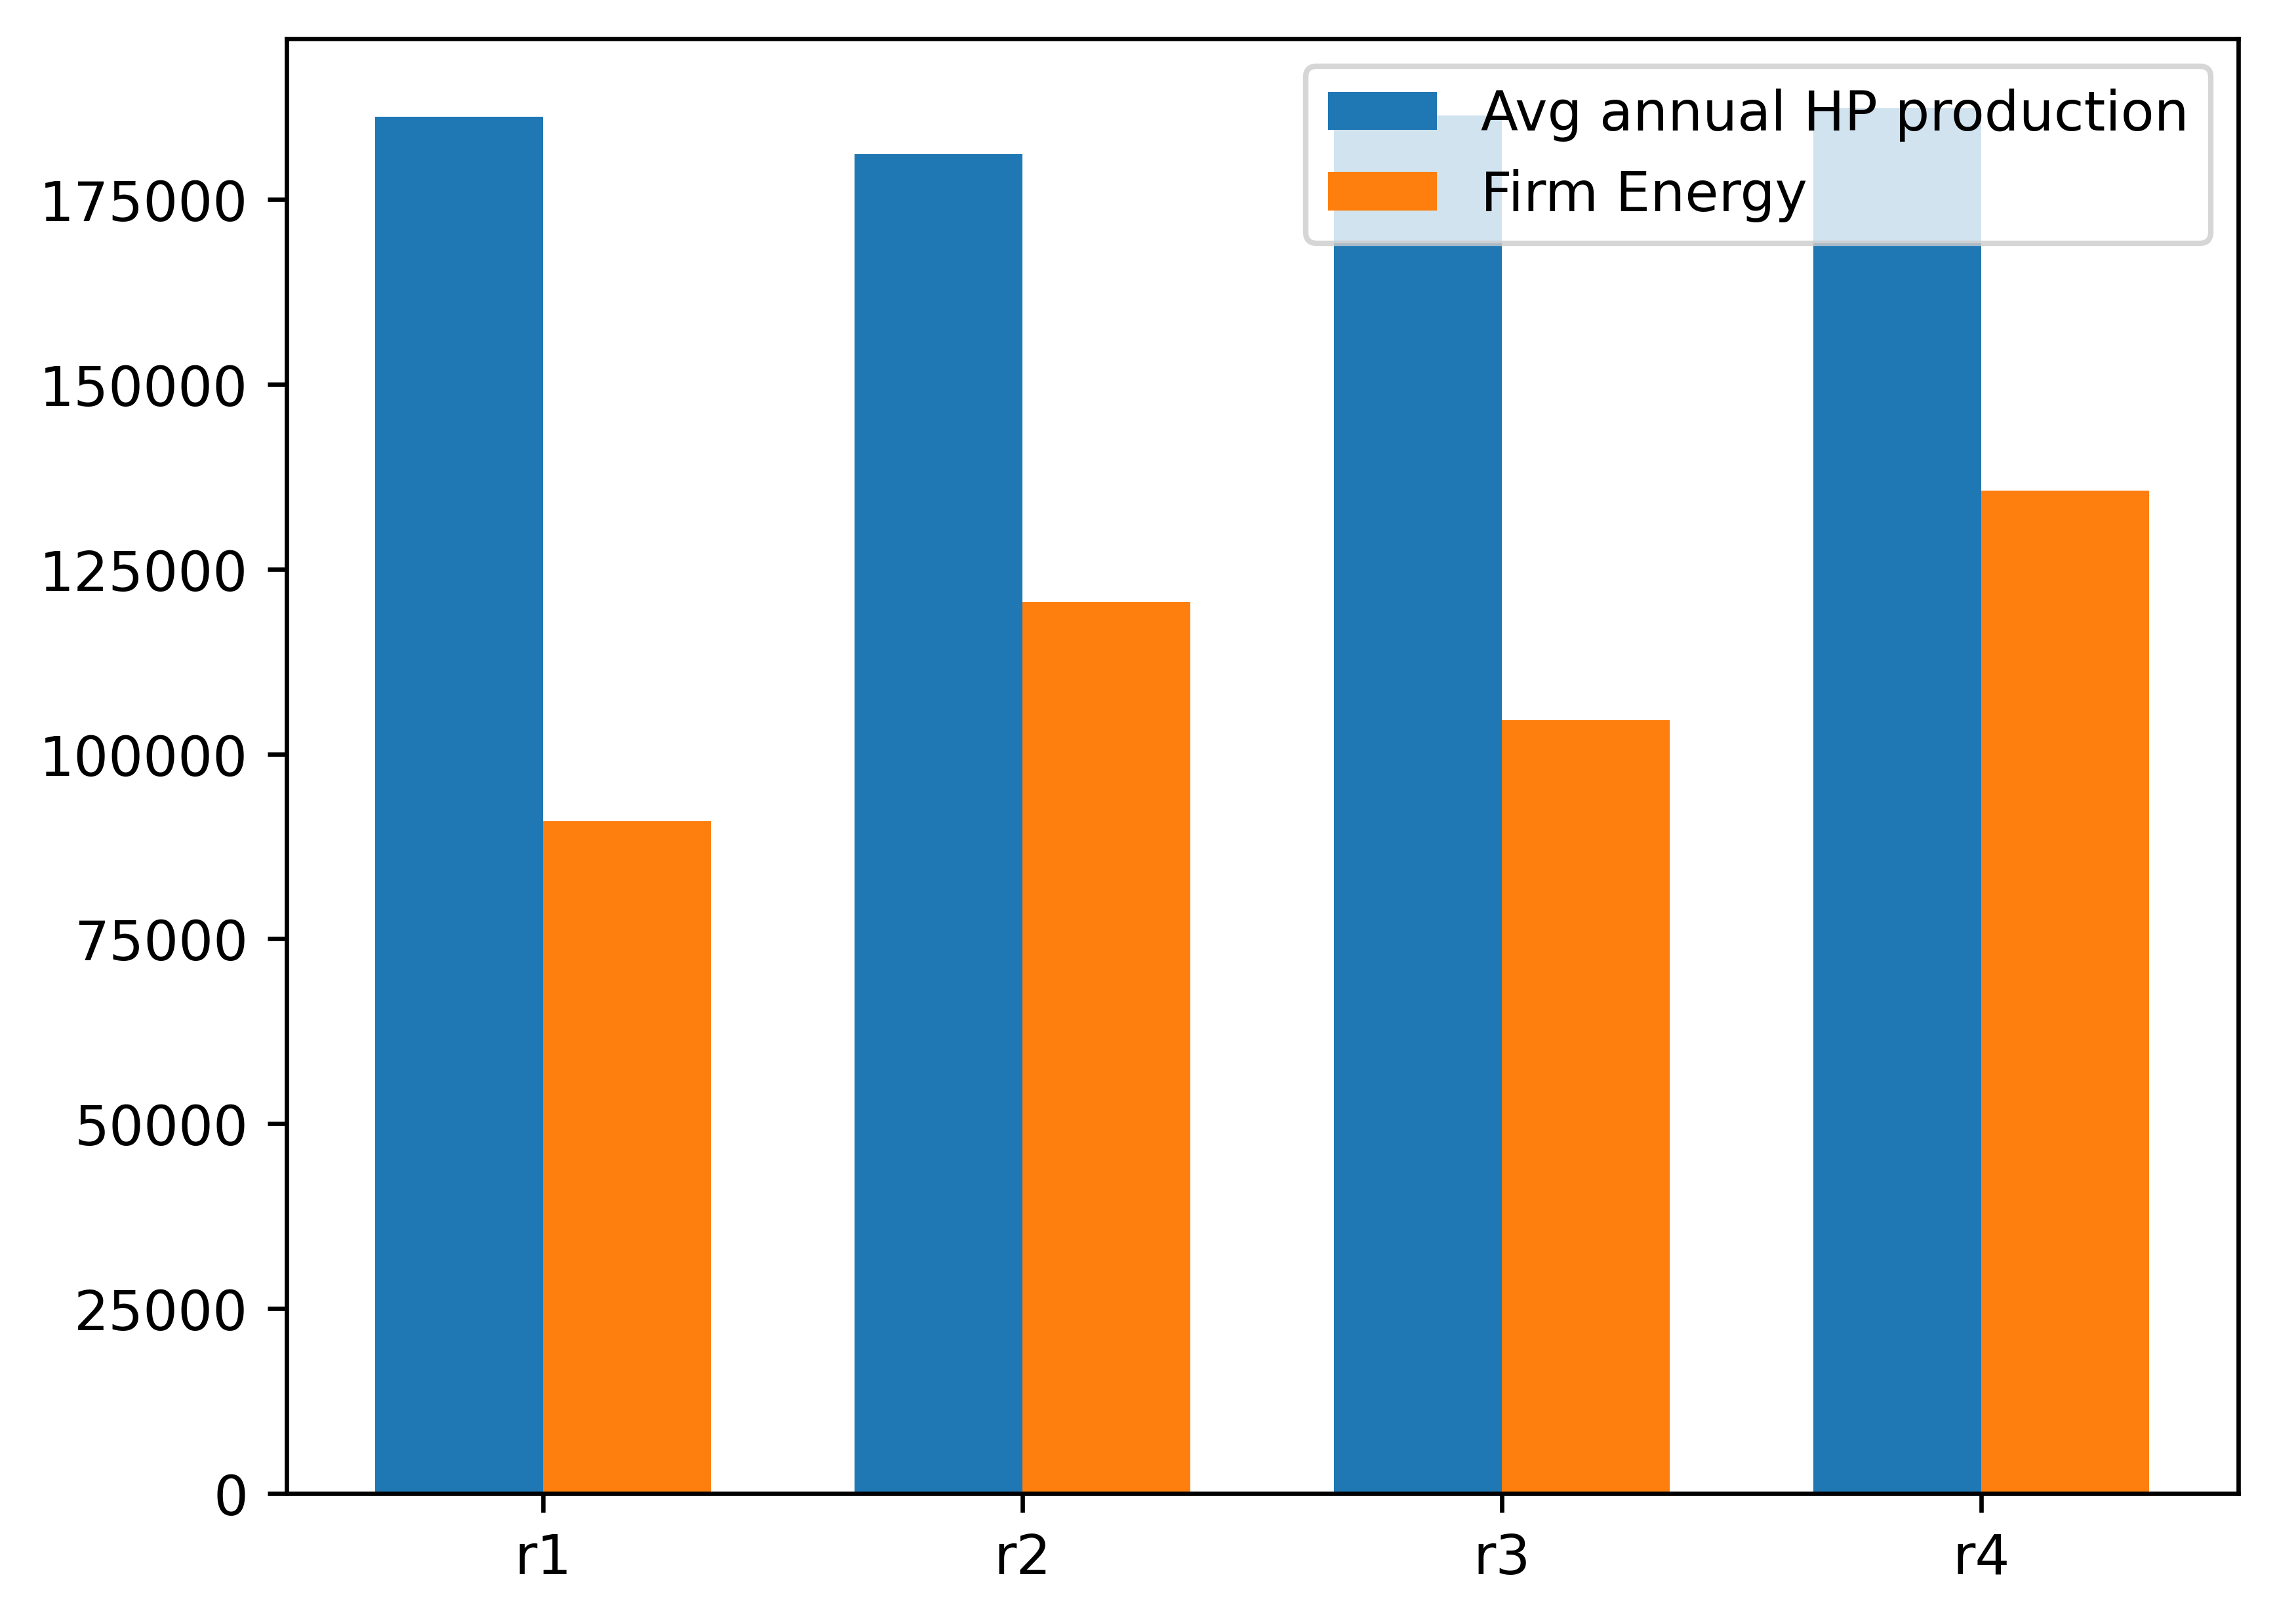

In [ ]:
# option 1: average annual production

Jenergy1 = [ np.mean(hp1)*365, np.mean(hp2)*365, np.mean(hp3)*365, np.mean(hp4)*365]

# option 2: firm energy - minimum annual production
annual_hp1 = np.reshape(hp1, (Ny, 365) )
sum_annual_hp1 = np.sum( annual_hp1 , axis = 1)

sum_annual_hp2 = np.sum( np.reshape(hp2, (Ny, 365) ) , axis = 1) #consolidating in a single line of code
sum_annual_hp3 = np.sum( np.reshape(hp3, (Ny, 365) ) , axis = 1)
sum_annual_hp4 = np.sum( np.reshape(hp4, (Ny, 365) ) , axis = 1)

Jenergy2 = [ np.min(sum_annual_hp1), np.min(sum_annual_hp2), np.min(sum_annual_hp3), np.min(sum_annual_hp4) ]

#visualize both indicators
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Jenergy1, width, label='Avg annual HP production')
rects2 = ax.bar(x + width/2, Jenergy2, width, label='Firm Energy')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



---




##_Food: agricultural production_



We can evaluate this in terms of level of satisfaction of an agricultural demand. A squared formulation allows to penalize large concentrated deficit

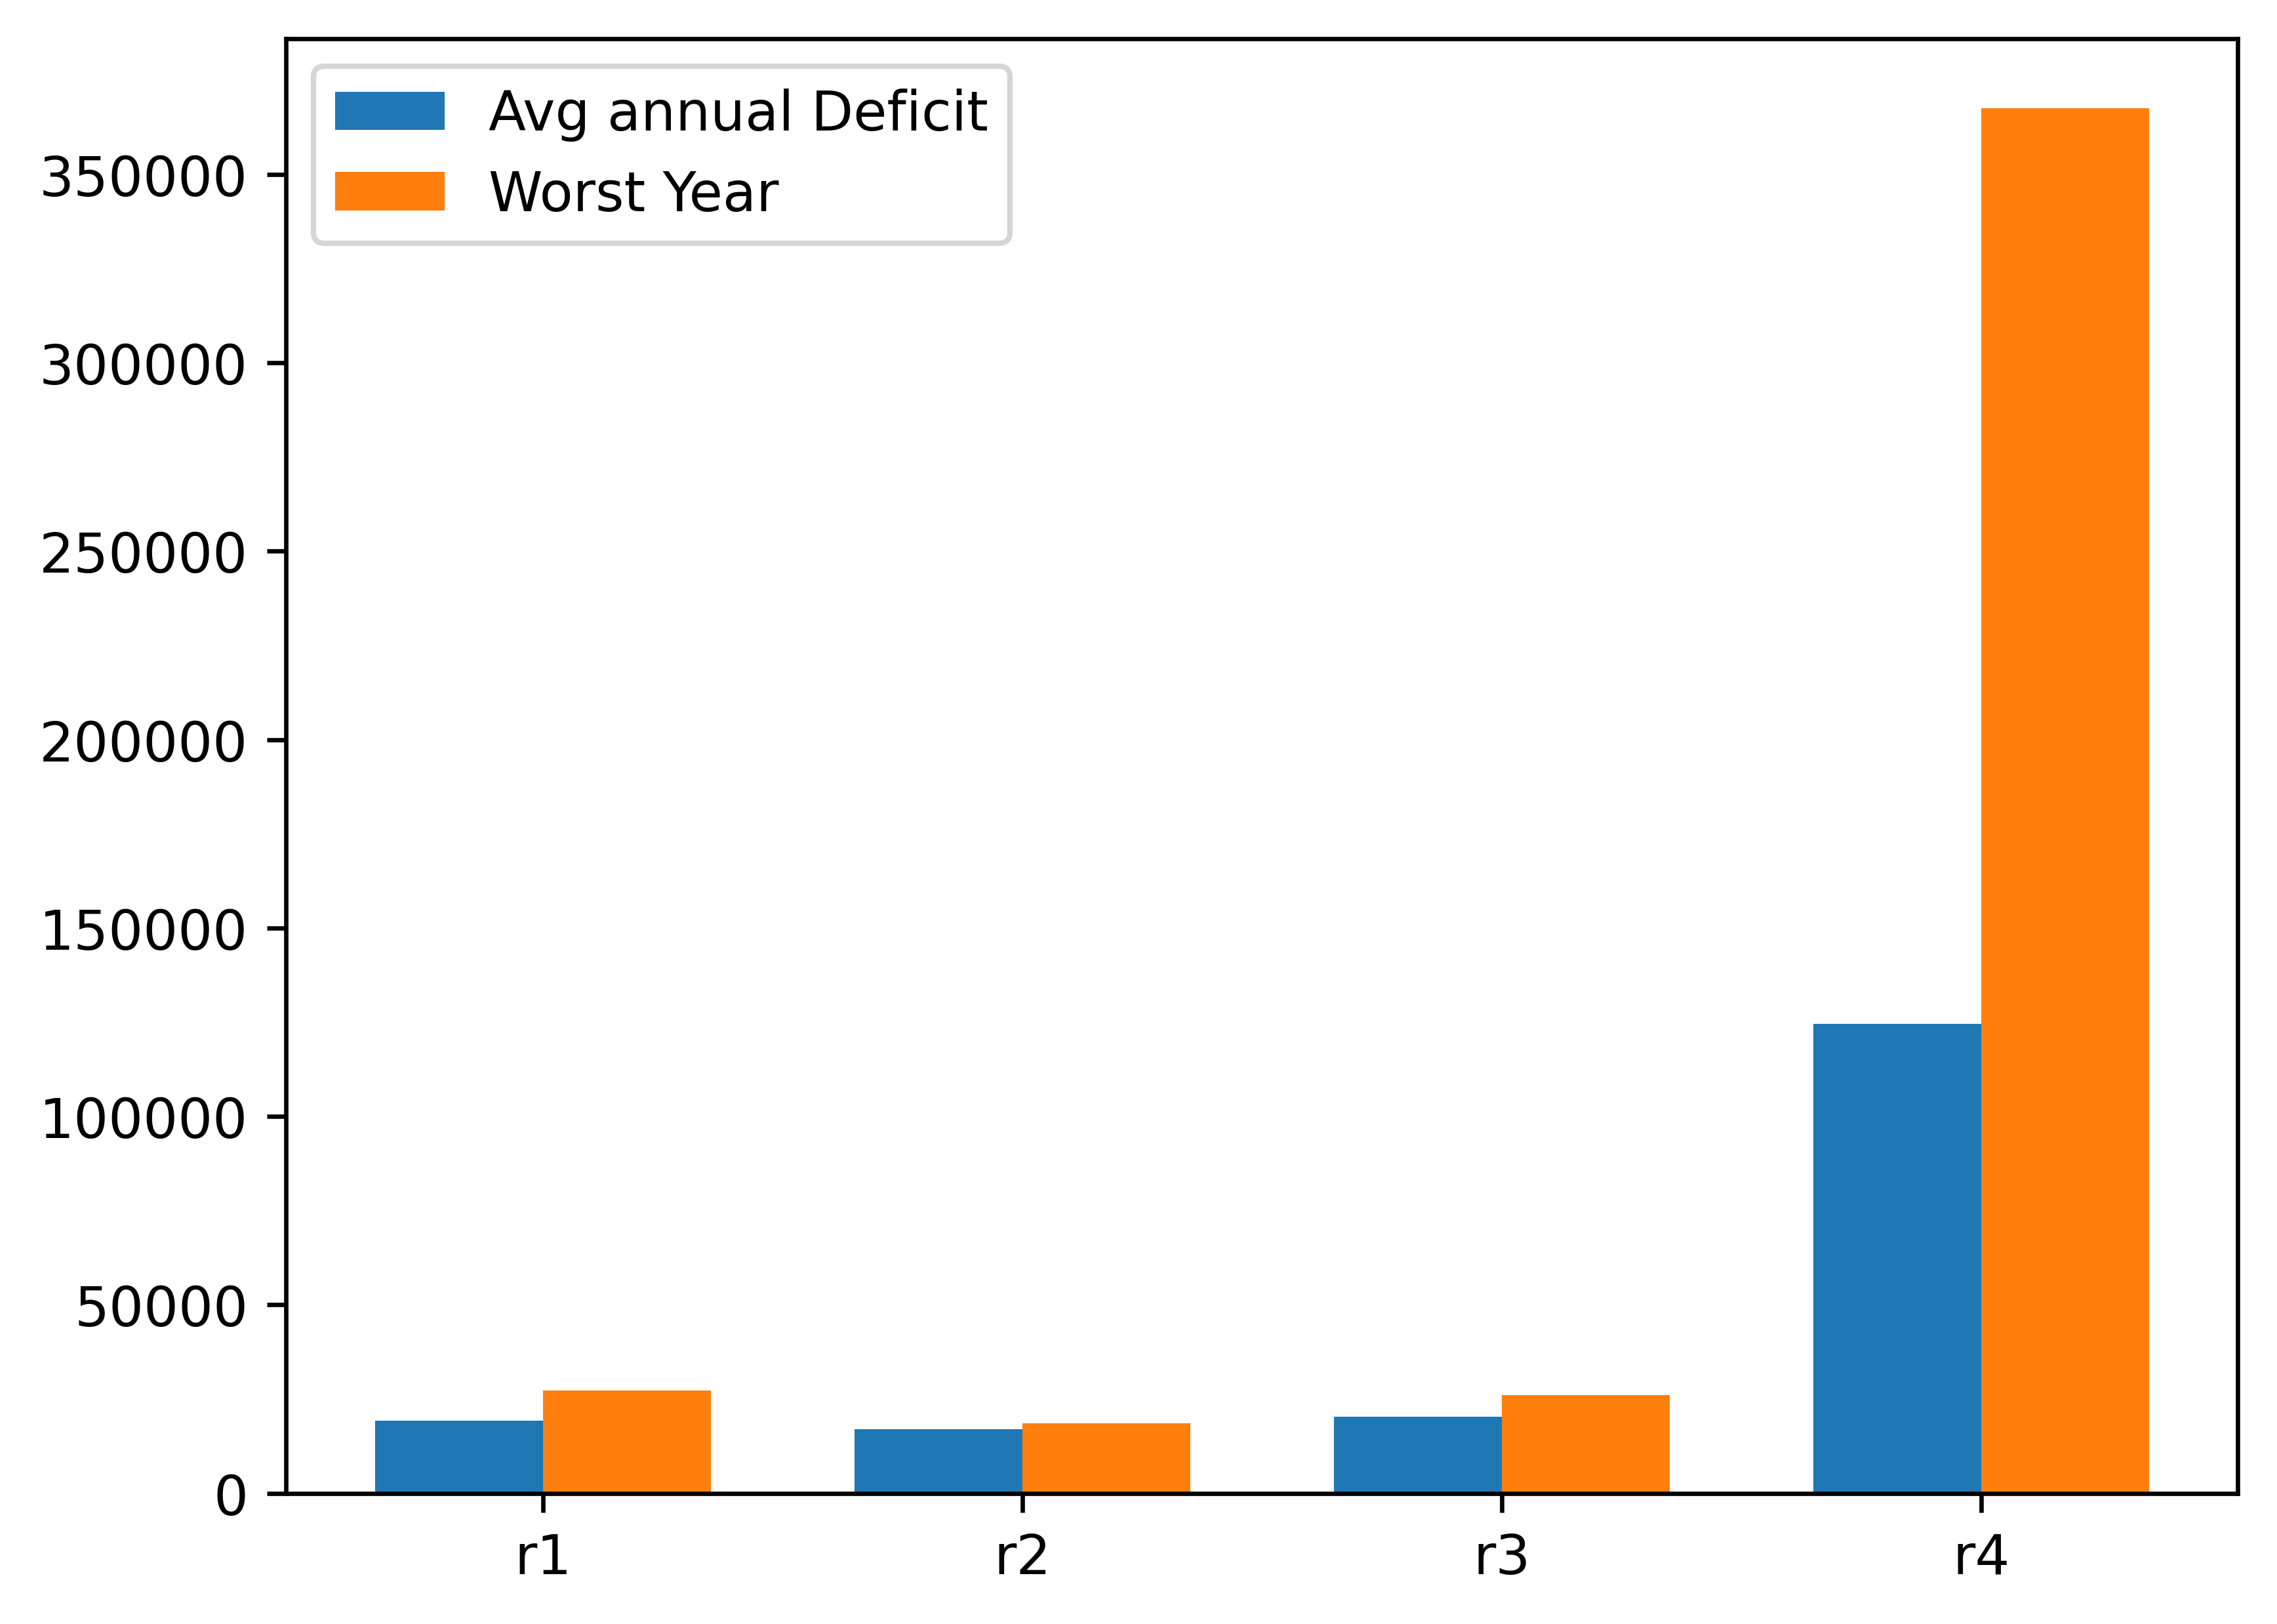

In [ ]:
D = 80 #assume daily constant water demand in m3/s
N = 2  # crop dependent
# calculate timeseries of agricultural deficit (ad)

ad_r1 = (np.maximum(D - r1, 0 )) ** N
ad_r2 = (np.maximum(D - r2, 0 )) ** N
ad_r3 = (np.maximum(D - r3, 0 )) ** N
ad_r4 = (np.maximum(D - r4, 0 )) ** N

# aggregate time series.

#Option 1: avg annual deficit
Jfood1 = [ np.mean(ad_r1)*365, np.mean(ad_r2)*365, np.mean(ad_r3)*365, np.mean(ad_r4)*365 ]

# Option 2: worst year
sum_annual_ad1 = np.sum( np.reshape(ad_r1, (Ny, 365) ) , axis = 1)
sum_annual_ad2 = np.sum( np.reshape(ad_r2, (Ny, 365) ) , axis = 1)
sum_annual_ad3 = np.sum( np.reshape(ad_r3, (Ny, 365) ) , axis = 1)
sum_annual_ad4 = np.sum( np.reshape(ad_r4, (Ny, 365) ) , axis = 1)

Jfood2 = [ np.max(sum_annual_ad1), np.max(sum_annual_ad2), np.max(sum_annual_ad3), np.max(sum_annual_ad4) ]

labels = ['r1', 'r2', 'r3', 'r4']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Jfood1, width, label='Avg annual Deficit')
rects2 = ax.bar(x + width/2, Jfood2, width, label='Worst Year')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

Other indicators may be reliability etc from NRM esercitazioni

---
## _Flood indicators_

for example, flood on lake shores when lake level > dam height

<BarContainer object of 4 artists>

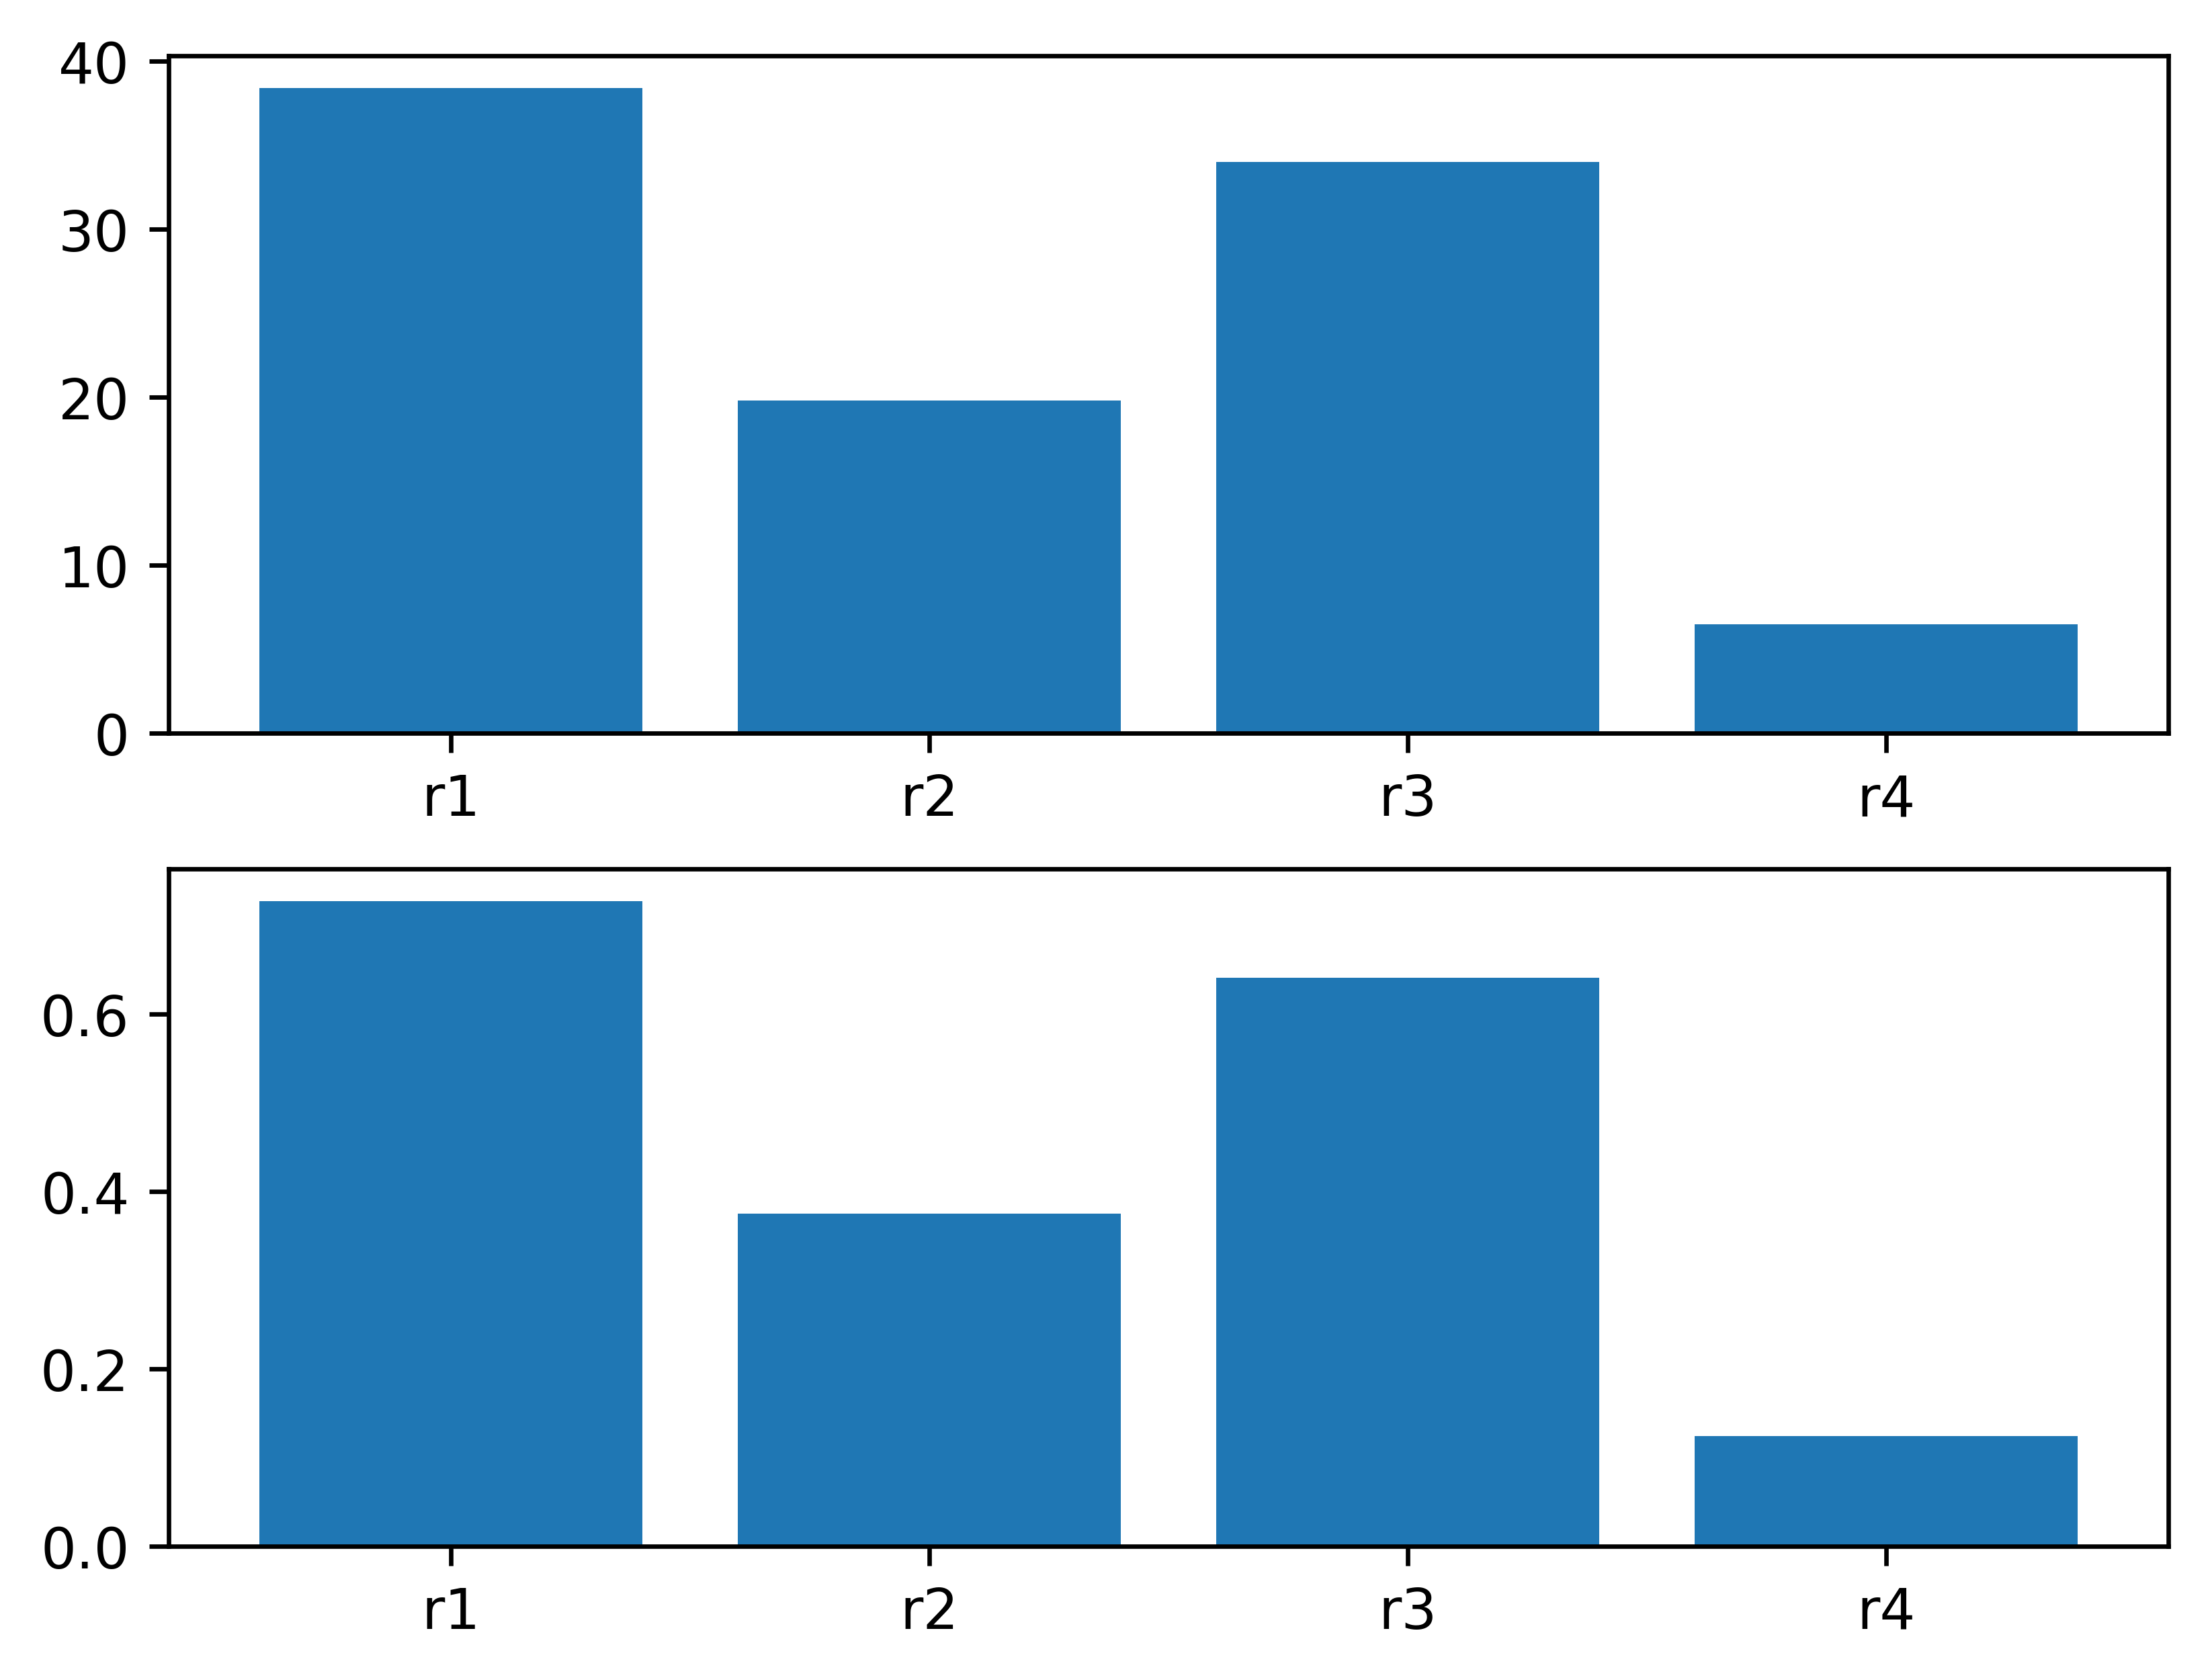

In [ ]:
dam_height = 232.1 #m

# average number of flood days per year
flood_days_1 = l1>= dam_height
flood_days_2 = l2>= dam_height
flood_days_3 = l3>= dam_height
flood_days_4 = l4>= dam_height

# aggregate as annual average

H = len(l1)
Ny = H/365
Jflood1 = [np.sum(flood_days_1)/Ny, np.sum(flood_days_2)/Ny, np.sum(flood_days_3)/Ny, np.sum(flood_days_4)/Ny] #average annual flood days


# flood magnitude
flood_magn_1 = l1[flood_days_1] - dam_height
flood_magn_2 = l2[flood_days_2] - dam_height
flood_magn_3 = l3[flood_days_3] - dam_height
flood_magn_4 = l4[flood_days_4] - dam_height

# aggregate as annual average
Jflood2 = [np.sum(flood_magn_1)/Ny, np.sum(flood_magn_2)/Ny, np.sum(flood_magn_3)/Ny, np.sum(flood_magn_4)/Ny] #average annual flood magnitude

plt.subplot(2,1,1)
plt.bar(labels, Jflood1)


plt.subplot(2,1,2)
plt.bar(labels, Jflood2)





---

# Which release policy is best?
... it depends of what indicators we care about. Let's make some plots to highlight tradeoffs:

_The tradeoff between 2 indicators are well represented by a scatterplot:_

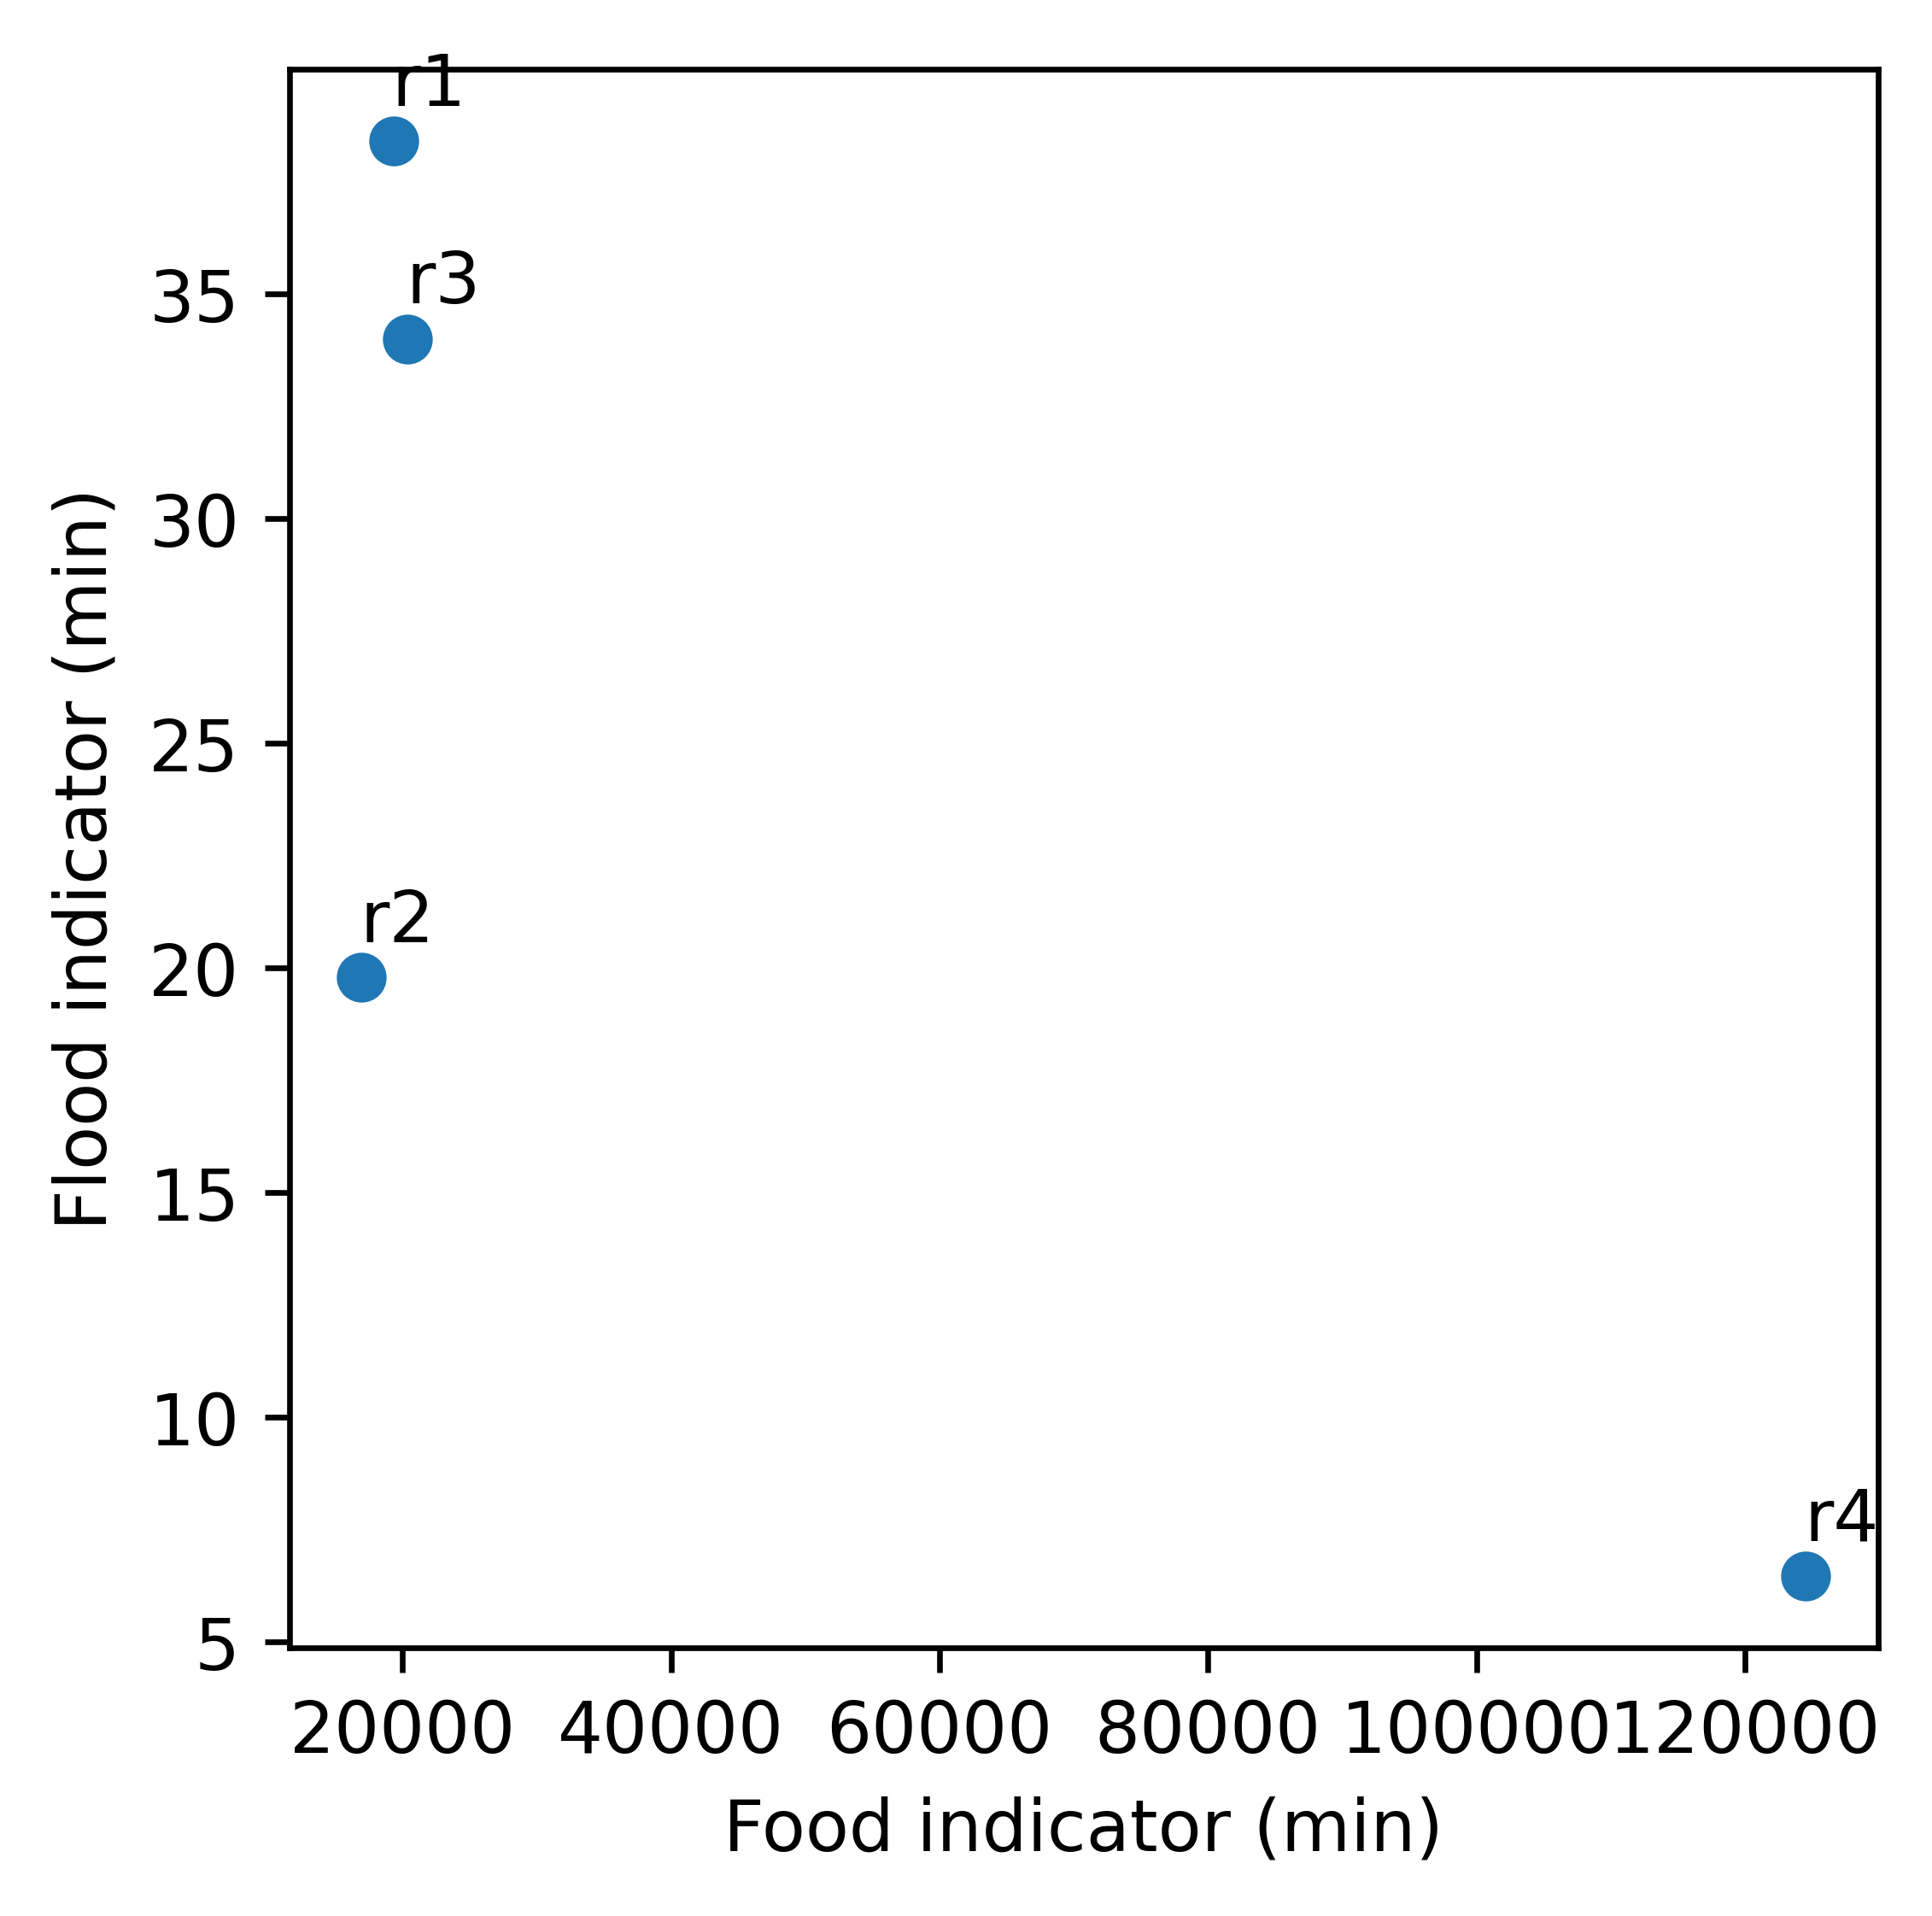

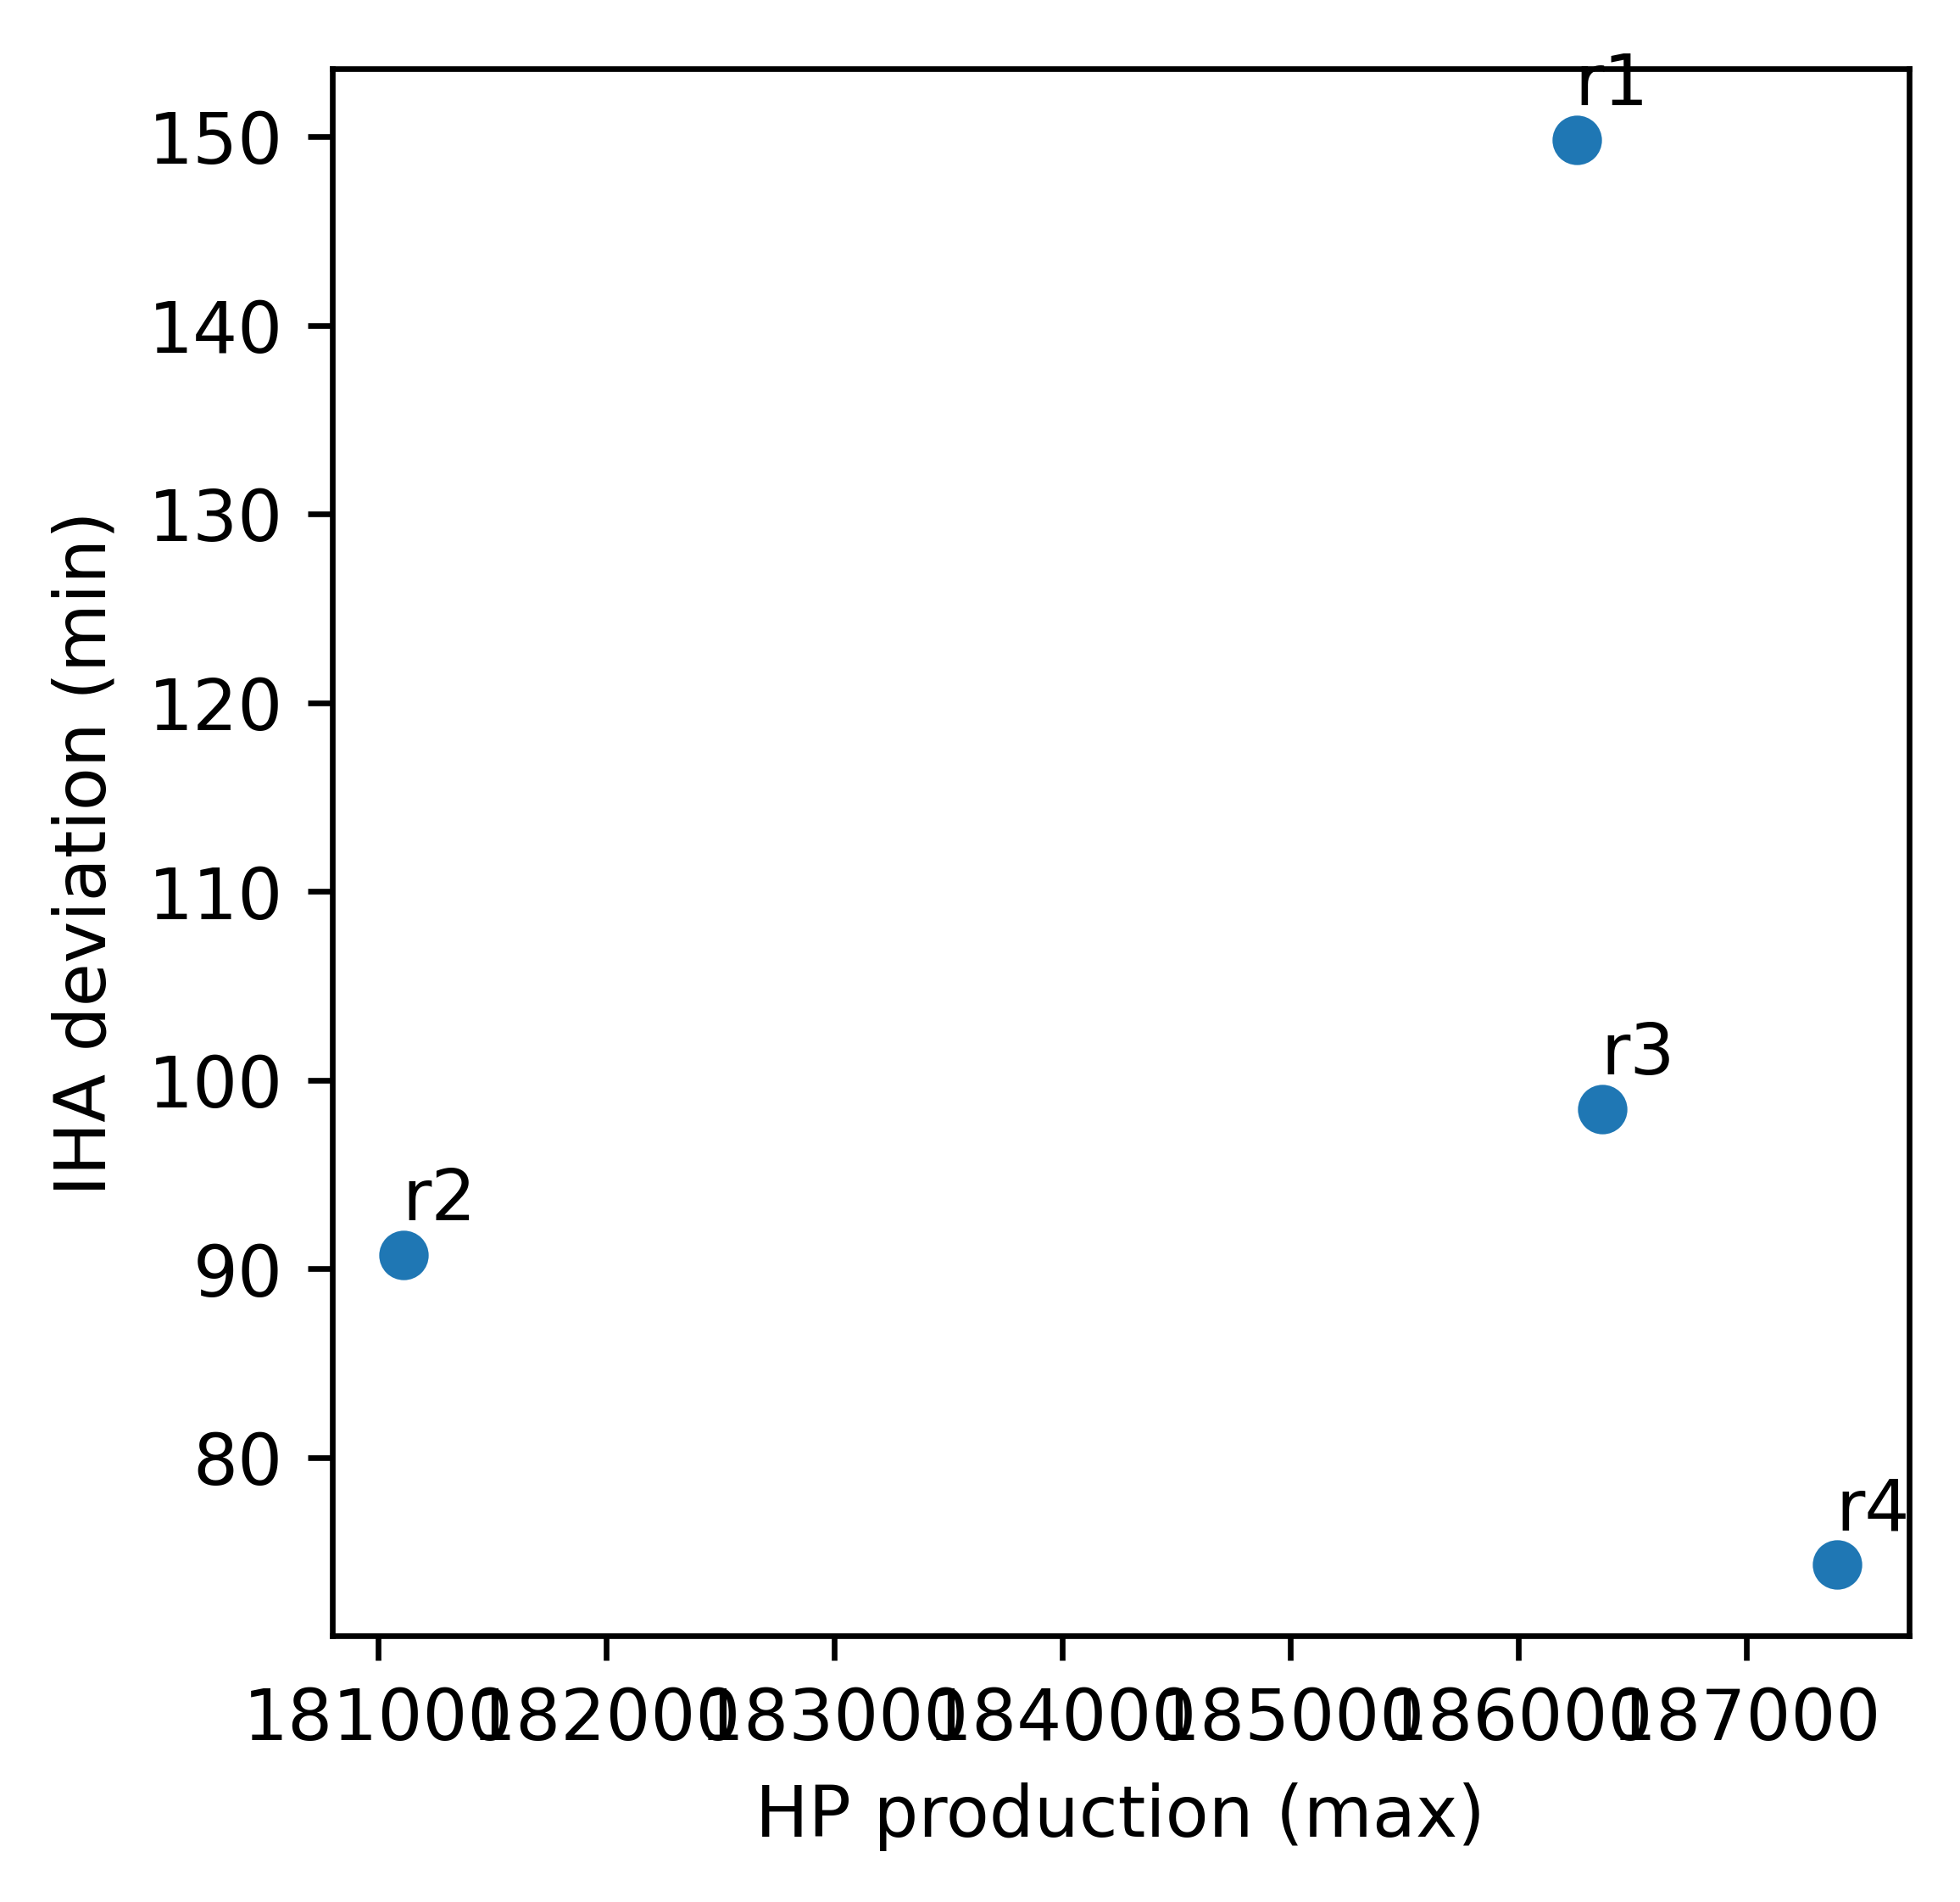

In [ ]:

# Set figure size
plt.figure(figsize=(4, 4))

# Create scatter plot
x = Jfood1
y = Jflood1

# Create scatter plot
plt.scatter(x, y)

# Label each point
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='center')

# Label the x and y axes
plt.xlabel('Food indicator (min)')
plt.ylabel('Flood indicator (min)')

plt.show()





# Set figure size
plt.figure(figsize=(4, 4))

# Create scatter plot
w = Jenergy1
z = Jenvironment1

# Create scatter plot
plt.scatter(w, z)

# Label each point
for i, label in enumerate(labels):
    plt.annotate(label, (w[i], z[i]), textcoords="offset points", xytext=(5, 5), ha='center')

# Label the x and y axes
plt.xlabel('HP production (max)')
plt.ylabel('IHA deviation (min)')

# Display the plot
plt.show()

_The tradeoff between 3 indicators can be represented with a 3D scatterplot, or a 2D scatterplot with the addition of size or color:_

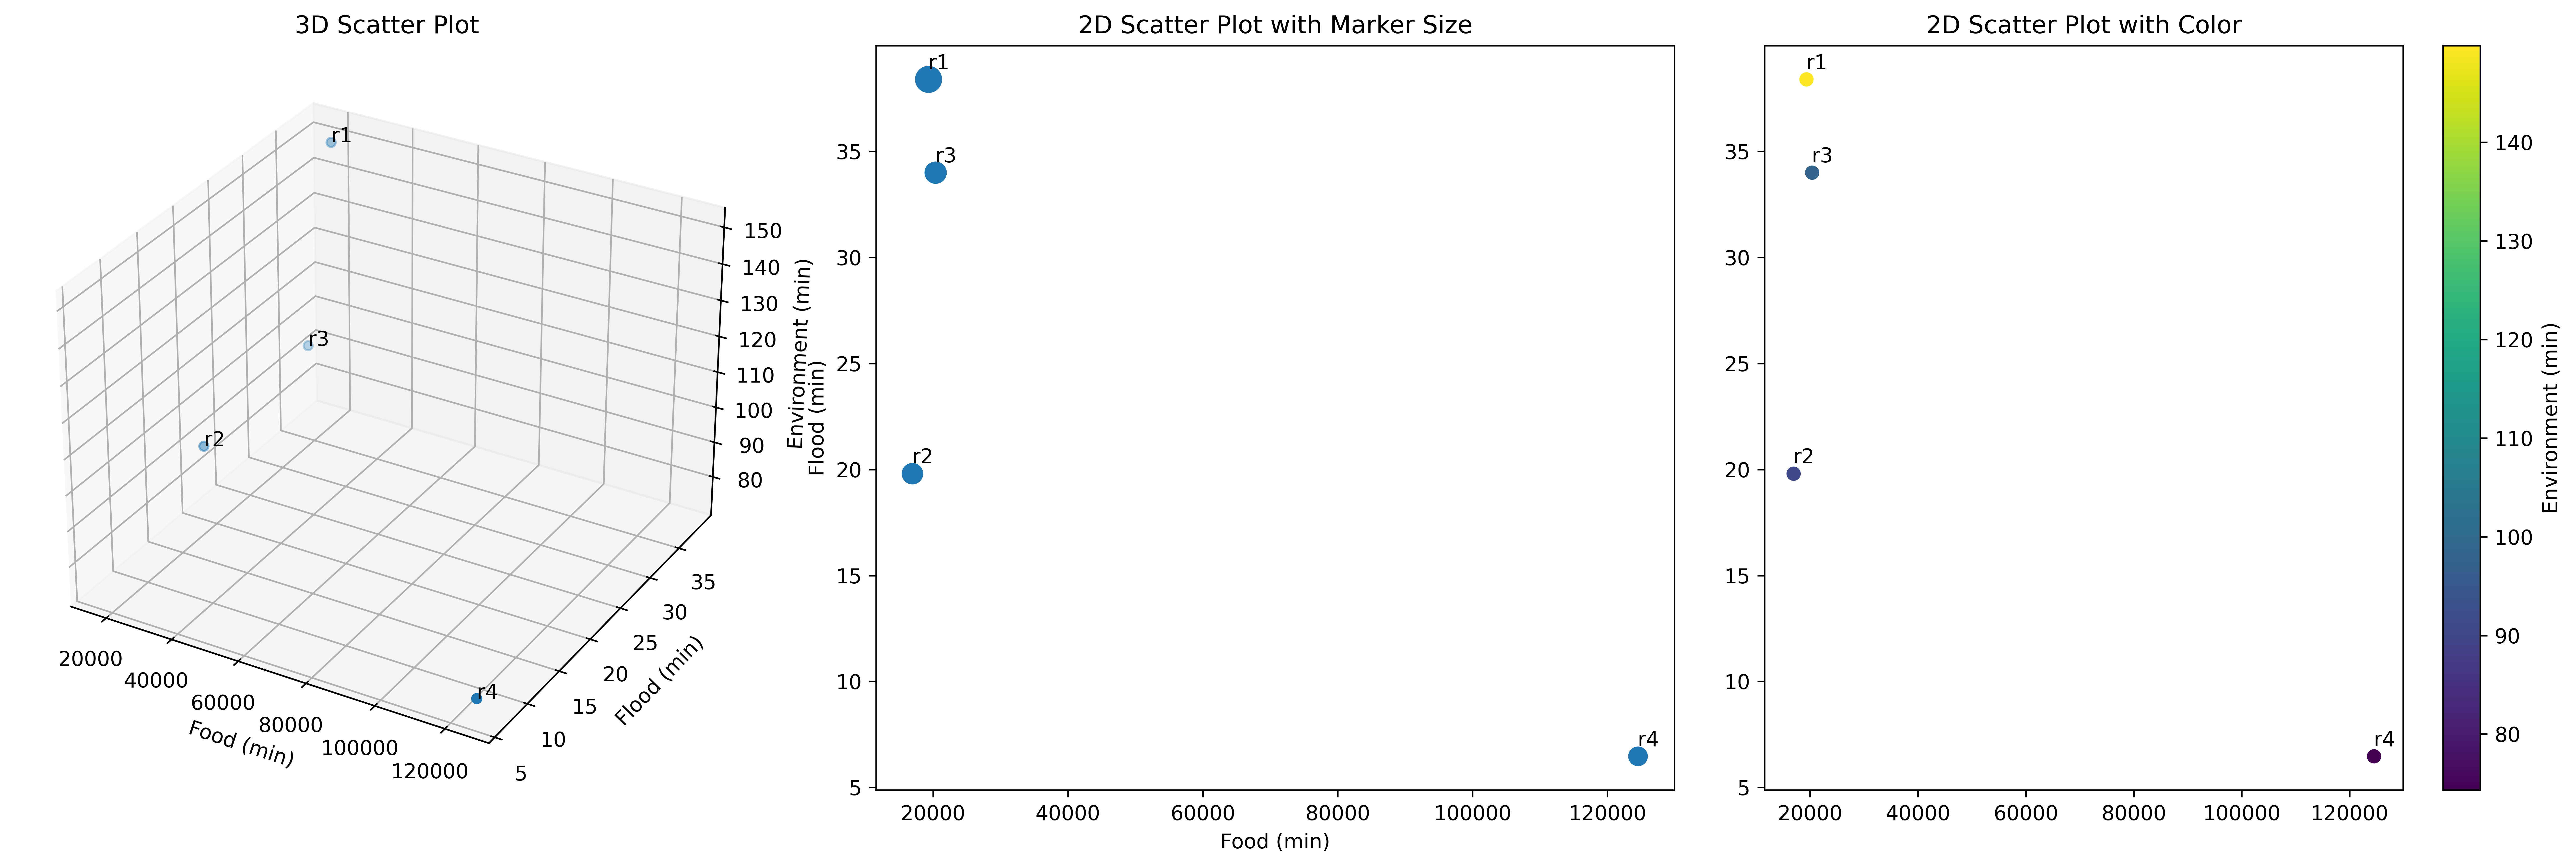

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(18, 6))

# First panel: 3D scatter plot
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(x, y, z)
ax1.set_xlabel('Food (min)')
ax1.set_ylabel('Flood (min)')
ax1.set_zlabel('Environment (min)')
for i, label in enumerate(labels):
    ax1.text(x[i], y[i], z[i], label)
ax1.set_title('3D Scatter Plot')

# Second panel: 2D scatter plot with marker size for the third dimension
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(x, y, s=z)  # scale marker size by z
ax2.set_xlabel('Food (min)')
ax2.set_ylabel('Flood (min)')
for i, label in enumerate(labels):
    ax2.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='center')
ax2.set_title('2D Scatter Plot with Marker Size')

# Third panel: 2D scatter plot with color for the third dimension
ax3 = fig.add_subplot(133)
sc3 = ax3.scatter(x, y, c=z, cmap='viridis')  # use z to color the markers
ax2.set_xlabel('Food (min)')
ax2.set_ylabel('Flood (min)')
for i, label in enumerate(labels):
    ax3.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='center')
ax3.set_title('2D Scatter Plot with Color')
plt.colorbar(sc3, ax=ax3, label='Environment (min)')

plt.tight_layout()
plt.show()


More dimensions are usually represented with a Parallel Axis plot:

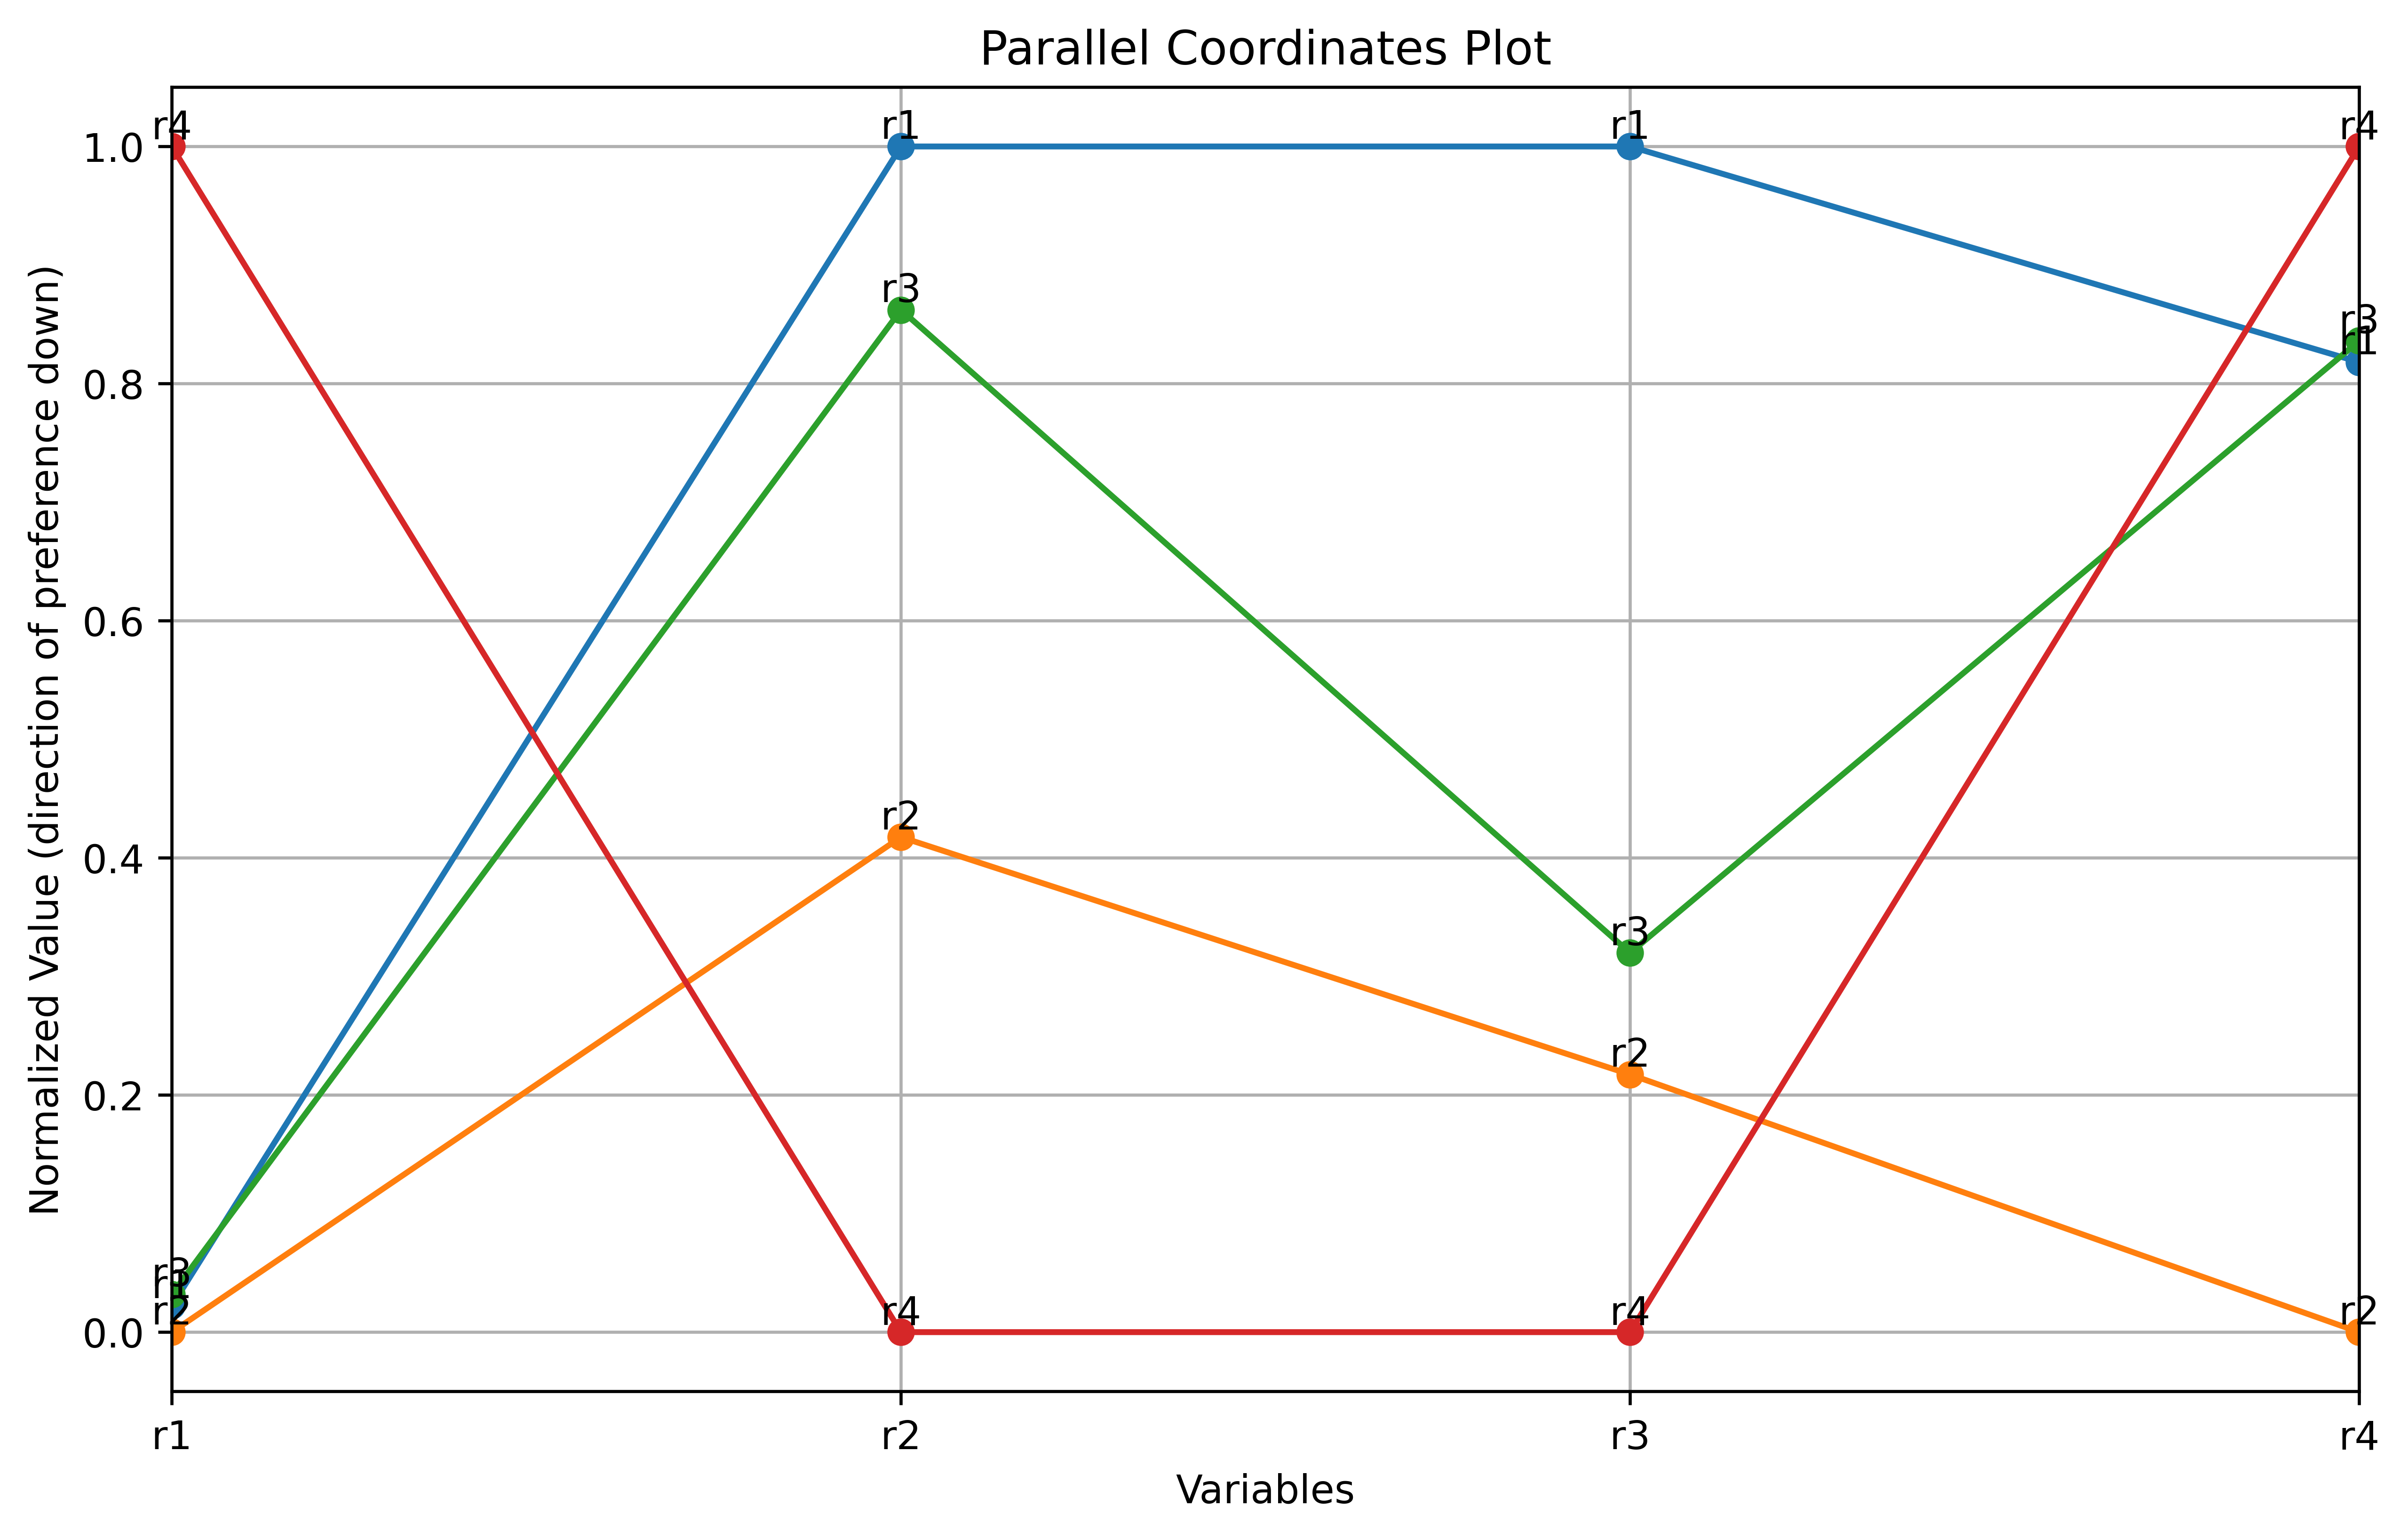

In [ ]:

# Combine the data into a single array
neg_w = w # the direction os preference for all indicator is minimum, except for HP production (w). We add the. minus sign to match direction of preference
data = np.vstack([x, y, z, neg_w]).T

# Normalize the data to 0-1 range for each dimension.
data_normalized = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Number of variables
num_vars = data.shape[1]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each data point
for i in range(len(data_normalized)):
    ax.plot(range(num_vars), data_normalized[i, :], marker='o', label=labels[i])
    for j in range(num_vars):
        ax.text(j, data_normalized[i, j], labels[i], ha='center', va='bottom')

# Set the ticks and labels
ax.set_xticks(range(num_vars))
ax.set_xticklabels(labels)
ax.set_xlim([0, num_vars - 1])

# Add grid lines for better readability
ax.grid(True)

# Set axis labels
ax.set_xlabel('Variables')
ax.set_ylabel('Normalized Value (direction of preference down)')

# Add a title
plt.title('Parallel Coordinates Plot')

plt.show()

